# Customer Personality Analysis

**Need to perform clustering to summarize customer segments.**

*В данной работе разделим клиентов на кластеры, опираясь на различные характеристики. Датасет взят с [Kaggle](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)*

## Содержание <a class="anchor" id="0"></a>

1. [Описание признаков](#1)
2. [Импорты библиотек](#2)
3. [Загрузка датасета](#3)
4. [Исследование датасета](#4)
5. [Подготовка данных](#5)
   - 5.1 [Очистка данных (Data Cleaning)](#5.1)
   - 5.2 [Создание новых признаков (Feature Engineering)](#5.2)
6. [Кластеризация](#6)
7. [Заключение](#7)

## 1. Описание признаков <a class="anchor" id="1"></a>

[Наверх](#0)

**People**

1) **ID**: *уникальный идентификатор клиента;*
2) **Year_Birth**: *год рождения клиента;*
3) **Education**: *образование клиента;*
4) **Marital_Status**: *семейный статус клиента;*
5) **Income**: *ежегодный доход клиента;*
6) **Kidhome**: *количество детей в семье;*
7) **Teenhome**: *количество подростков в семье;*
8) **Dt_Customer**: *дата регистрации клиента на сайте;*
9) **Recency**: *количество дней с момента последней покупки клиента;*
10) **Complain**: *1, если клиент жаловался на обслуживание за последние два года, 0 в противном случае;*

**Products**

11) **MntWines**: *сумма, потраченная на вина за последние два года;*
12) **MntFruits**: *сумма, потраченная на фрукты за последние два года;*
13) **MntMeatProducts**: *сумма, потраченная на мясо за последние два года;*
14) **MntFishProducts**: *сумма, потраченная на рыбу за последние два года;*
15) **MntSweetProducts**: *сумма, потраченная на сладости за последние два года;*
16) **MntGoldProds**: *сумма, потраченная на золото за последние два года;*

**Promotion**

17) **NumDealsPurchases**: *количество покупок, совершённых со скидкой;*
18) **AcceptedCmp1**: *1, если клиент участвовал в 1-й рекламной кампании, 0 в противном случае;*
19) **AcceptedCmp2**: *1, если клиент участвовал во 2-й рекламной кампании, 0 в противном случае;*
20) **AcceptedCmp3**: *1, если клиент участвовал в 3-й рекламной кампании, 0 в противном случае;*
21) **AcceptedCmp4**: *1, если клиент участвовал в 4-й рекламной кампании, 0 в противном случае;*
22) **AcceptedCmp5**: *1, если клиент участвовал в 5-й рекламной кампании, 0 в противном случае;*
23) **Response**: *1, если клиент участвовал в последней рекламной кампании, 0 в противном случае;*

**Place**

24) **NumWebPurchases**: *количество покупок, совершённых через сайт;*
25) **NumCatalogPurchases**: *количество покупок, совершённых используя каталог;*
26) **NumStorePurchases**: *количество покупок, совершённых непосредственно в магазинах;*
27) **NumWebVisitsMonth**: *количество визитов сайта компании за последний месяц.*

## 2. Импорты библиотек <a class="anchor" id="2"></a>

[Наверх](#0)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## 3. Загрузка датасета <a class="anchor" id="3"></a>

[Наверх](#0)

Импортируем необходимые модули для работы с файлами и API Kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from zipfile import ZipFile

Определим две константы. **DATASET_NAME** берём из Kaggle API команды, а в **PATH** запишем каталог, в который сохраним csv-файл с датасетом

In [3]:
DATASET_NAME = 'imakash3011/customer-personality-analysis'
PATH = 'data'

In [4]:
def load_dataset():
    if not Path(PATH).is_dir():
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(DATASET_NAME, path=PATH)
        zip_path = PATH + '/' + DATASET_NAME.split('/')[1] + '.zip'
        with ZipFile(zip_path, 'r') as zip:
            zip.extractall(PATH)
        Path(zip_path).unlink(missing_ok=True)
        print('Файл успешно загружен')
    return pd.read_csv(Path(PATH).iterdir().__next__(), sep=',')

In [5]:
df = load_dataset()

## 4. Исследование датасета <a class="anchor" id="4"></a>

[Наверх](#0)

In [6]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  NumStorePurchases  \
0  2012-09-04       58       635  ...                   10                  4   
1  2014-03-08       38        11  ...                    1                  2   
2  2013-08-21       26       426  ...                    2                 10   
3  2014-02-10       26        11  ...                    0                  4   
4  2014-01-19       94       173  ...                    3                  6   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   
3                  6             0             0             0             0   
4                  5             0             0             0             0   

   AcceptedCmp2  Complain  Response  
0             0         0         1  
1             0         0         0  
2             0         0         0  
3             0         0         0  
4             0         0         0  

[5 rows x 27 columns]

Оценим размер датасета

In [7]:
df.shape

(2240, 27)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Первым делом проверим уникальность **ID**

In [9]:
df.ID.nunique()

2240

Все пользователи уникальны. Теперь посмотрим, есть ли пропуски в данных

In [10]:
df.isna().sum()[df.isna().sum()>0]

Income    24
dtype: int64

Видим, что только у одного признака есть пропуски. Посмотрим эти объекты

In [11]:
df[df.Income.isna()]

ID  Year_Birth   Education Marital_Status  Income  Kidhome  Teenhome  \
10     1994        1983  Graduation        Married     NaN        1         0   
27     5255        1986  Graduation         Single     NaN        1         0   
43     7281        1959         PhD         Single     NaN        0         0   
48     7244        1951  Graduation         Single     NaN        2         1   
58     8557        1982  Graduation         Single     NaN        1         0   
71    10629        1973    2n Cycle        Married     NaN        1         0   
90     8996        1957         PhD        Married     NaN        2         1   
91     9235        1957  Graduation         Single     NaN        1         1   
92     5798        1973      Master       Together     NaN        0         0   
128    8268        1961         PhD        Married     NaN        0         1   
133    1295        1963  Graduation        Married     NaN        0         1   
312    2437        1989  Graduation        Married     NaN        0         0   
319    2863        1970  Graduation         Single     NaN        1         2   
1379  10475        1970      Master       Together     NaN        0         1   
1382   2902        1958  Graduation       Together     NaN        1         1   
1383   4345        1964    2n Cycle         Single     NaN        1         1   
1386   3769        1972         PhD       Together     NaN        1         0   
2059   7187        1969      Master       Together     NaN        1         1   
2061   1612        1981         PhD         Single     NaN        1         0   
2078   5079        1971  Graduation        Married     NaN        1         1   
2079  10339        1954      Master       Together     NaN        0         1   
2081   3117        1955  Graduation         Single     NaN        0         1   
2084   5250        1943      Master          Widow     NaN        0         0   
2228   8720        1978    2n Cycle       Together     NaN        0         0   

     Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  \
10    2013-11-15       11         5  ...                    0   
27    2013-02-20       19         5  ...                    0   
43    2013-11-05       80        81  ...                    3   
48    2014-01-01       96        48  ...                    1   
58    2013-06-17       57        11  ...                    0   
71    2012-09-14       25        25  ...                    0   
90    2012-11-19        4       230  ...                    2   
91    2014-05-27       45         7  ...                    0   
92    2013-11-23       87       445  ...                    4   
128   2013-07-11       23       352  ...                    1   
133   2013-08-11       96       231  ...                    5   
312   2013-06-03       69       861  ...                    5   
319   2013-08-23       67       738  ...                    3   
1379  2013-04-01       39       187  ...                    2   
1382  2012-09-03       87        19  ...                    0   
1383  2014-01-12       49         5  ...                    0   
1386  2014-03-02       17        25  ...                    0   
2059  2013-05-18       52       375  ...                   10   
2061  2013-05-31       82        23  ...                    0   
2078  2013-03-03       82        71  ...                    1   
2079  2013-06-23       83       161  ...                    1   
2081  2013-10-18       95       264  ...                    1   
2084  2013-10-30       75       532  ...                    5   
2228  2012-08-12       53        32  ...                    0   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
10                    2                  7             0             0   
27                    0                  1             0             0   
43                    4                  2             0             0   
48                    4                  6             0     

Не ясно, почему эти данные отсутствуют: либо у этих людей реально нет никакого дохода (что маловероятно), либо эти значения просто не внесли. Так как таких записей около 1 % от всей выборки, то удалим их

In [12]:
df = df[~df.Income.isna()]

Проверим дубликаты 

In [13]:
df.duplicated().sum()

0

In [14]:
df.describe().T

count          mean           std     min       25%  \
ID                   2216.0   5588.353339   3249.376275     0.0   2814.75   
Year_Birth           2216.0   1968.820397     11.985554  1893.0   1959.00   
Income               2216.0  52247.251354  25173.076661  1730.0  35303.00   
Kidhome              2216.0      0.441787      0.536896     0.0      0.00   
Teenhome             2216.0      0.505415      0.544181     0.0      0.00   
Recency              2216.0     49.012635     28.948352     0.0     24.00   
MntWines             2216.0    305.091606    337.327920     0.0     24.00   
MntFruits            2216.0     26.356047     39.793917     0.0      2.00   
MntMeatProducts      2216.0    166.995939    224.283273     0.0     16.00   
MntFishProducts      2216.0     37.637635     54.752082     0.0      3.00   
MntSweetProducts     2216.0     27.028881     41.072046     0.0      1.00   
MntGoldProds         2216.0     43.965253     51.815414     0.0      9.00   
NumDealsPurchases    2216.0      2.323556      1.923716     0.0      1.00   
NumWebPurchases      2216.0      4.085289      2.740951     0.0      2.00   
NumCatalogPurchases  2216.0      2.671029      2.926734     0.0      0.00   
NumStorePurchases    2216.0      5.800993      3.250785     0.0      3.00   
NumWebVisitsMonth    2216.0      5.319043      2.425359     0.0      3.00   
AcceptedCmp3         2216.0      0.073556      0.261106     0.0      0.00   
AcceptedCmp4         2216.0      0.074007      0.261842     0.0      0.00   
AcceptedCmp5         2216.0      0.073105      0.260367     0.0      0.00   
AcceptedCmp1         2216.0      0.064079      0.244950     0.0      0.00   
AcceptedCmp2         2216.0      0.013538      0.115588     0.0      0.00   
Complain             2216.0      0.009477      0.096907     0.0      0.00   
Response             2216.0      0.150271      0.357417     0.0      0.00   

                         50%       75%       max  
ID                    5458.5   8421.75   11191.0  
Year_Birth            1970.0   1977.00    1996.0  
Income               51381.5  68522.00  666666.0  
Kidhome                  0.0      1.00       2.0  
Teenhome                 0.0      1.00       2.0  
Recency                 49.0     74.00      99.0  
MntWines               174.5    505.00    1493.0  
MntFruits                8.0     33.00     199.0  
MntMeatProducts         68.0    232.25    1725.0  
MntFishProducts         12.0     50.00     259.0  
MntSweetProducts         8.0     33.00     262.0  
MntGoldProds            24.5     56.00     321.0  
NumDealsPurchases        2.0      3.00      15.0  
NumWebPurchases          4.0      6.00      27.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumStorePurchases        5.0      8.00      13.0  
NumWebVisitsMonth        6.0      7.00      20.0  
AcceptedCmp3             0.0      0.00       1.0  
AcceptedCmp4             0.0      0.00       1.0  
AcceptedCmp5             0.0      0.00       1.0  
AcceptedCmp1             0.0      0.00       1.0  
AcceptedCmp2             0.0      0.00       1.0  
Complain                 0.0      0.00       1.0  
Response                 0.0      0.00       1.0

Судя по максимальным значениям, у некоторых признаков имеются выбросы

In [15]:
df.describe(include=object)

Education Marital_Status Dt_Customer
count         2216           2216        2216
unique           5              8         662
top     Graduation        Married  2012-08-31
freq          1116            857          12

Категориальных признаков всего 3. Причём **Dt_Customer** представляет собой даты, но в текущий момент является строковым объектом. Извлечём из признака **Dt_Customer** день, год и месяц регистрации

In [16]:
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer)
df['Year'] = df.Dt_Customer.dt.year
df['Month'] = df.Dt_Customer.dt.month
df['Day'] = df.Dt_Customer.dt.day

Посмотрим на распределения

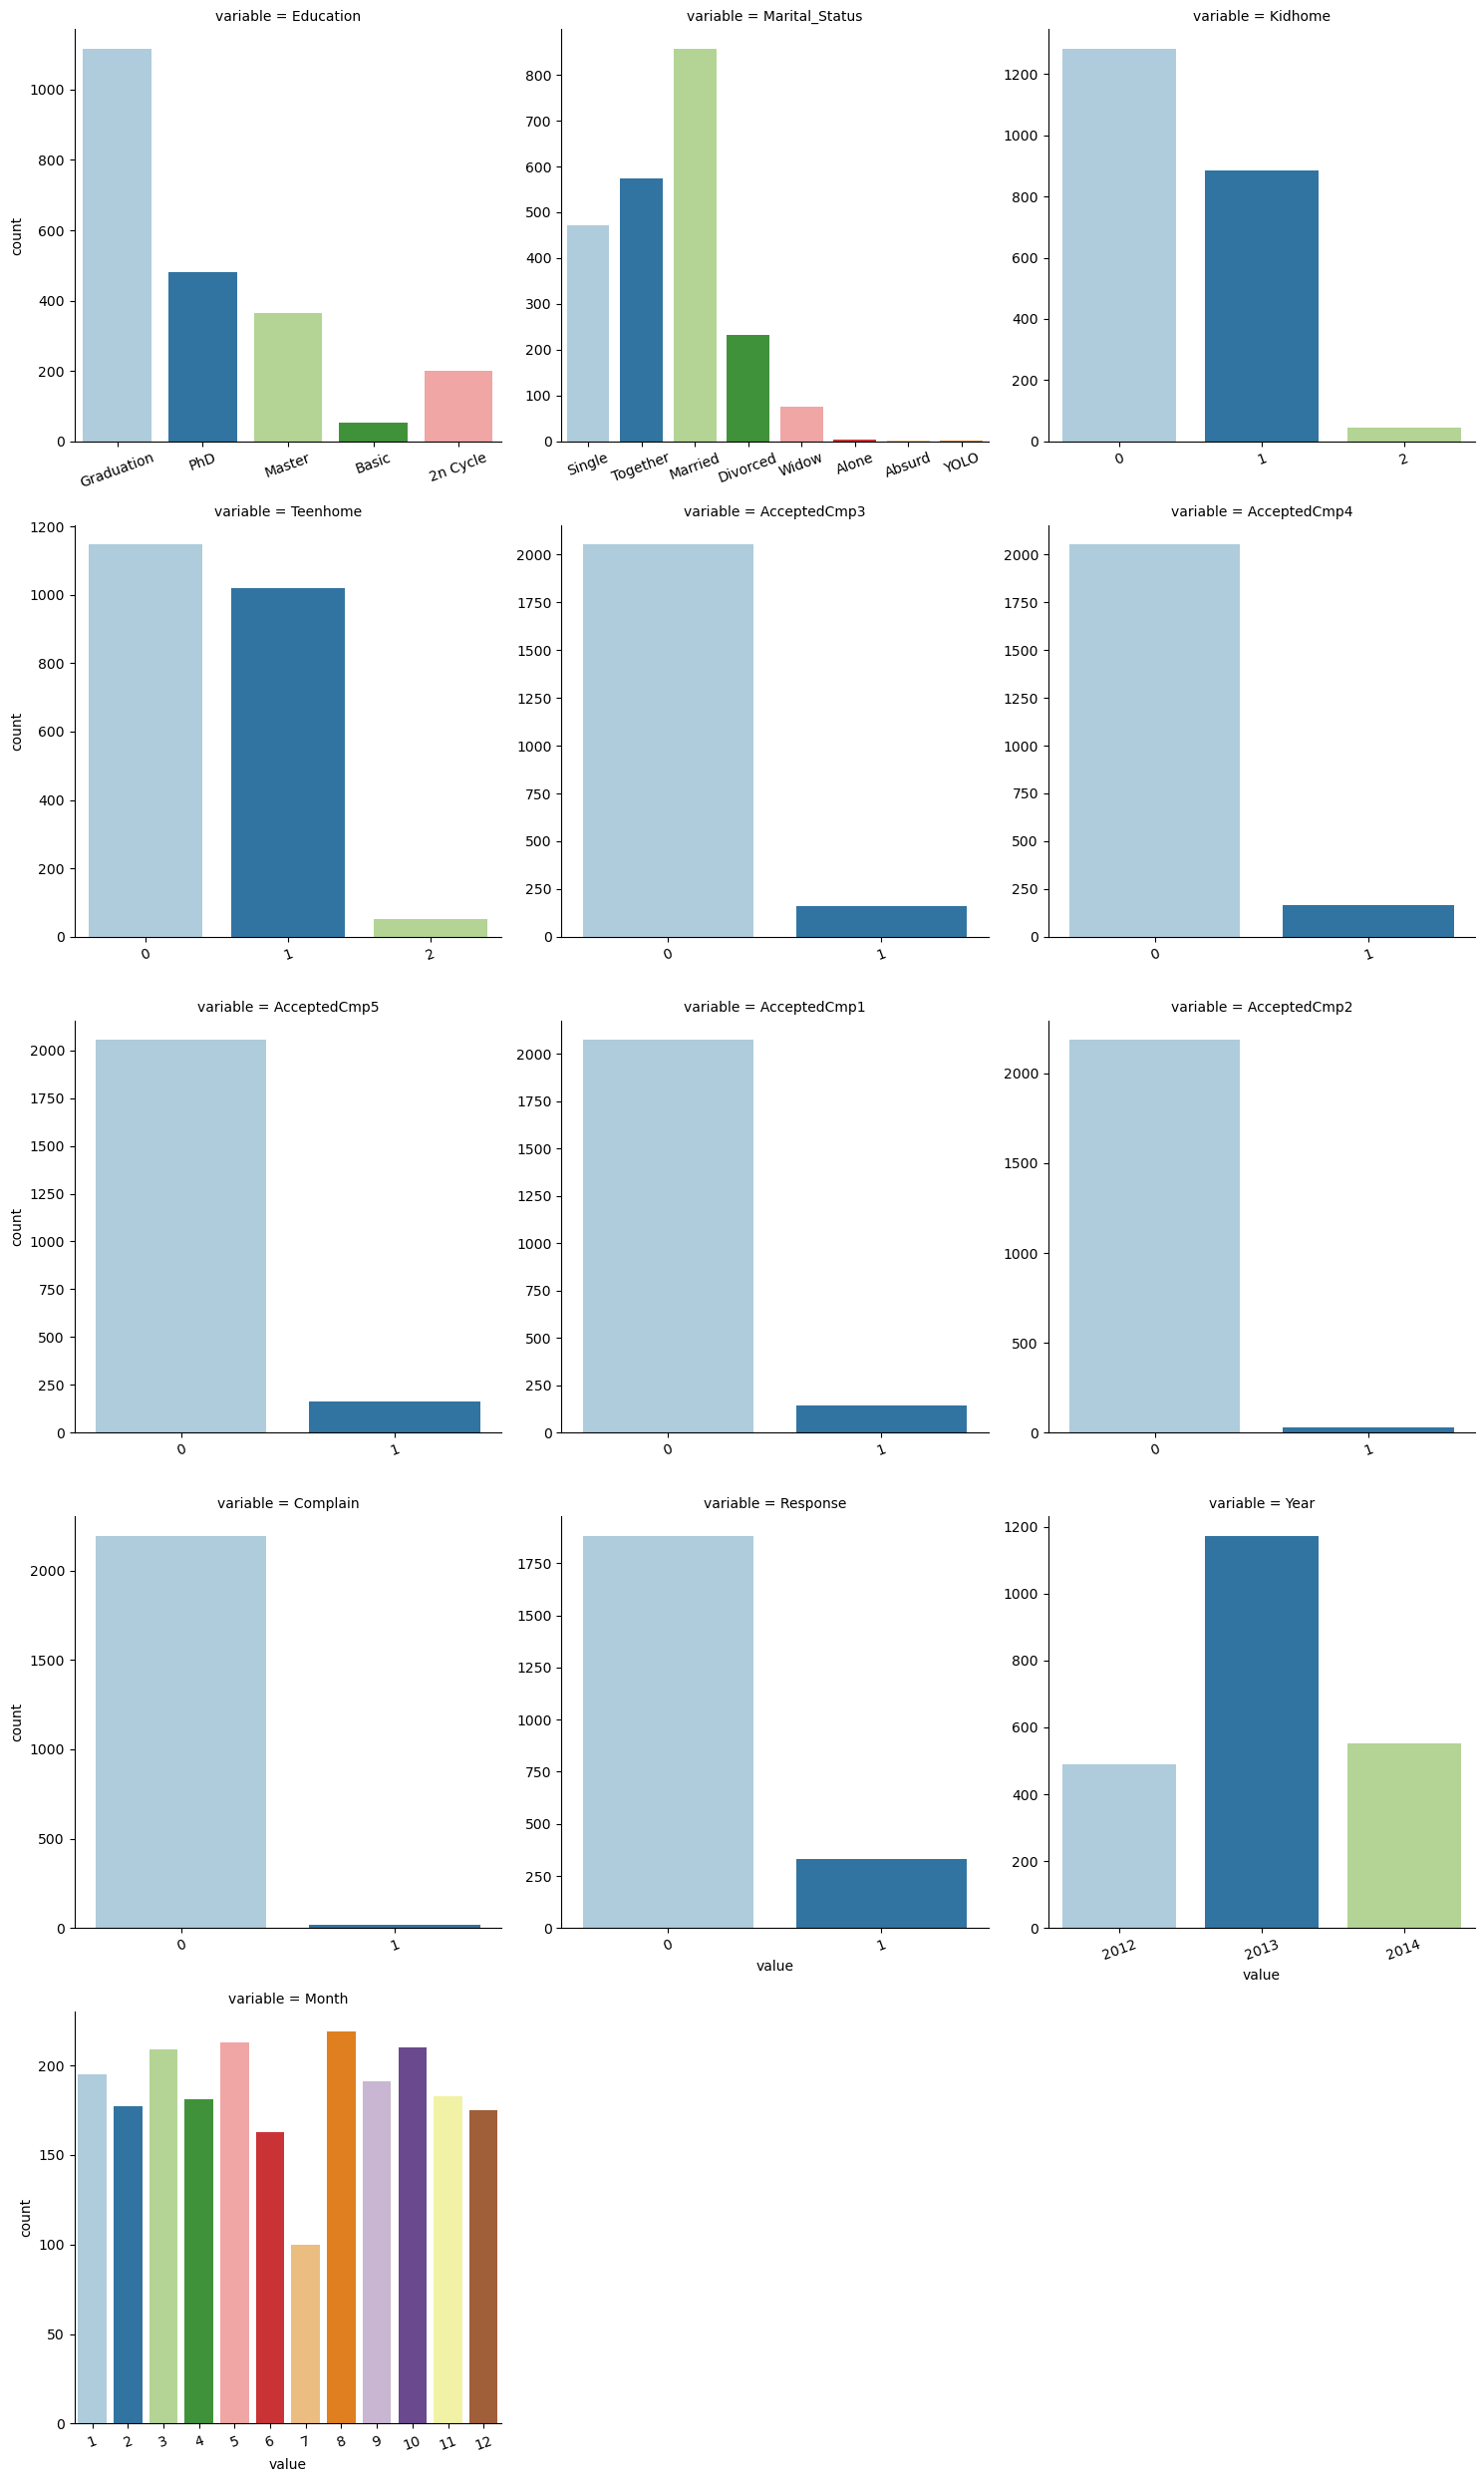

In [17]:
ax = sns.catplot(
    x='value',
    data=df.melt(
        value_vars=[f for f in df.columns if df[f].nunique()<=12]
    ),
    col='variable',
    kind='count',
    col_wrap=3,
    sharex=False, 
    sharey=False,
    palette='Paired'
)
ax.set_xticklabels(rotation=20)
ax.tight_layout();

Что интересного можно увидеть из этих графиков:
- большинство клиентов имеют высшее образование и состоят в браке;
- у многих клиентов нет детей;
- больше всего клиентов участвовало в последней рекламной компании;
- больше всего клиентов было зарегистрировано в 2013 году;
- меньше всего людей регистрируется в июне и июле, что совпадает с пиком отпусков.

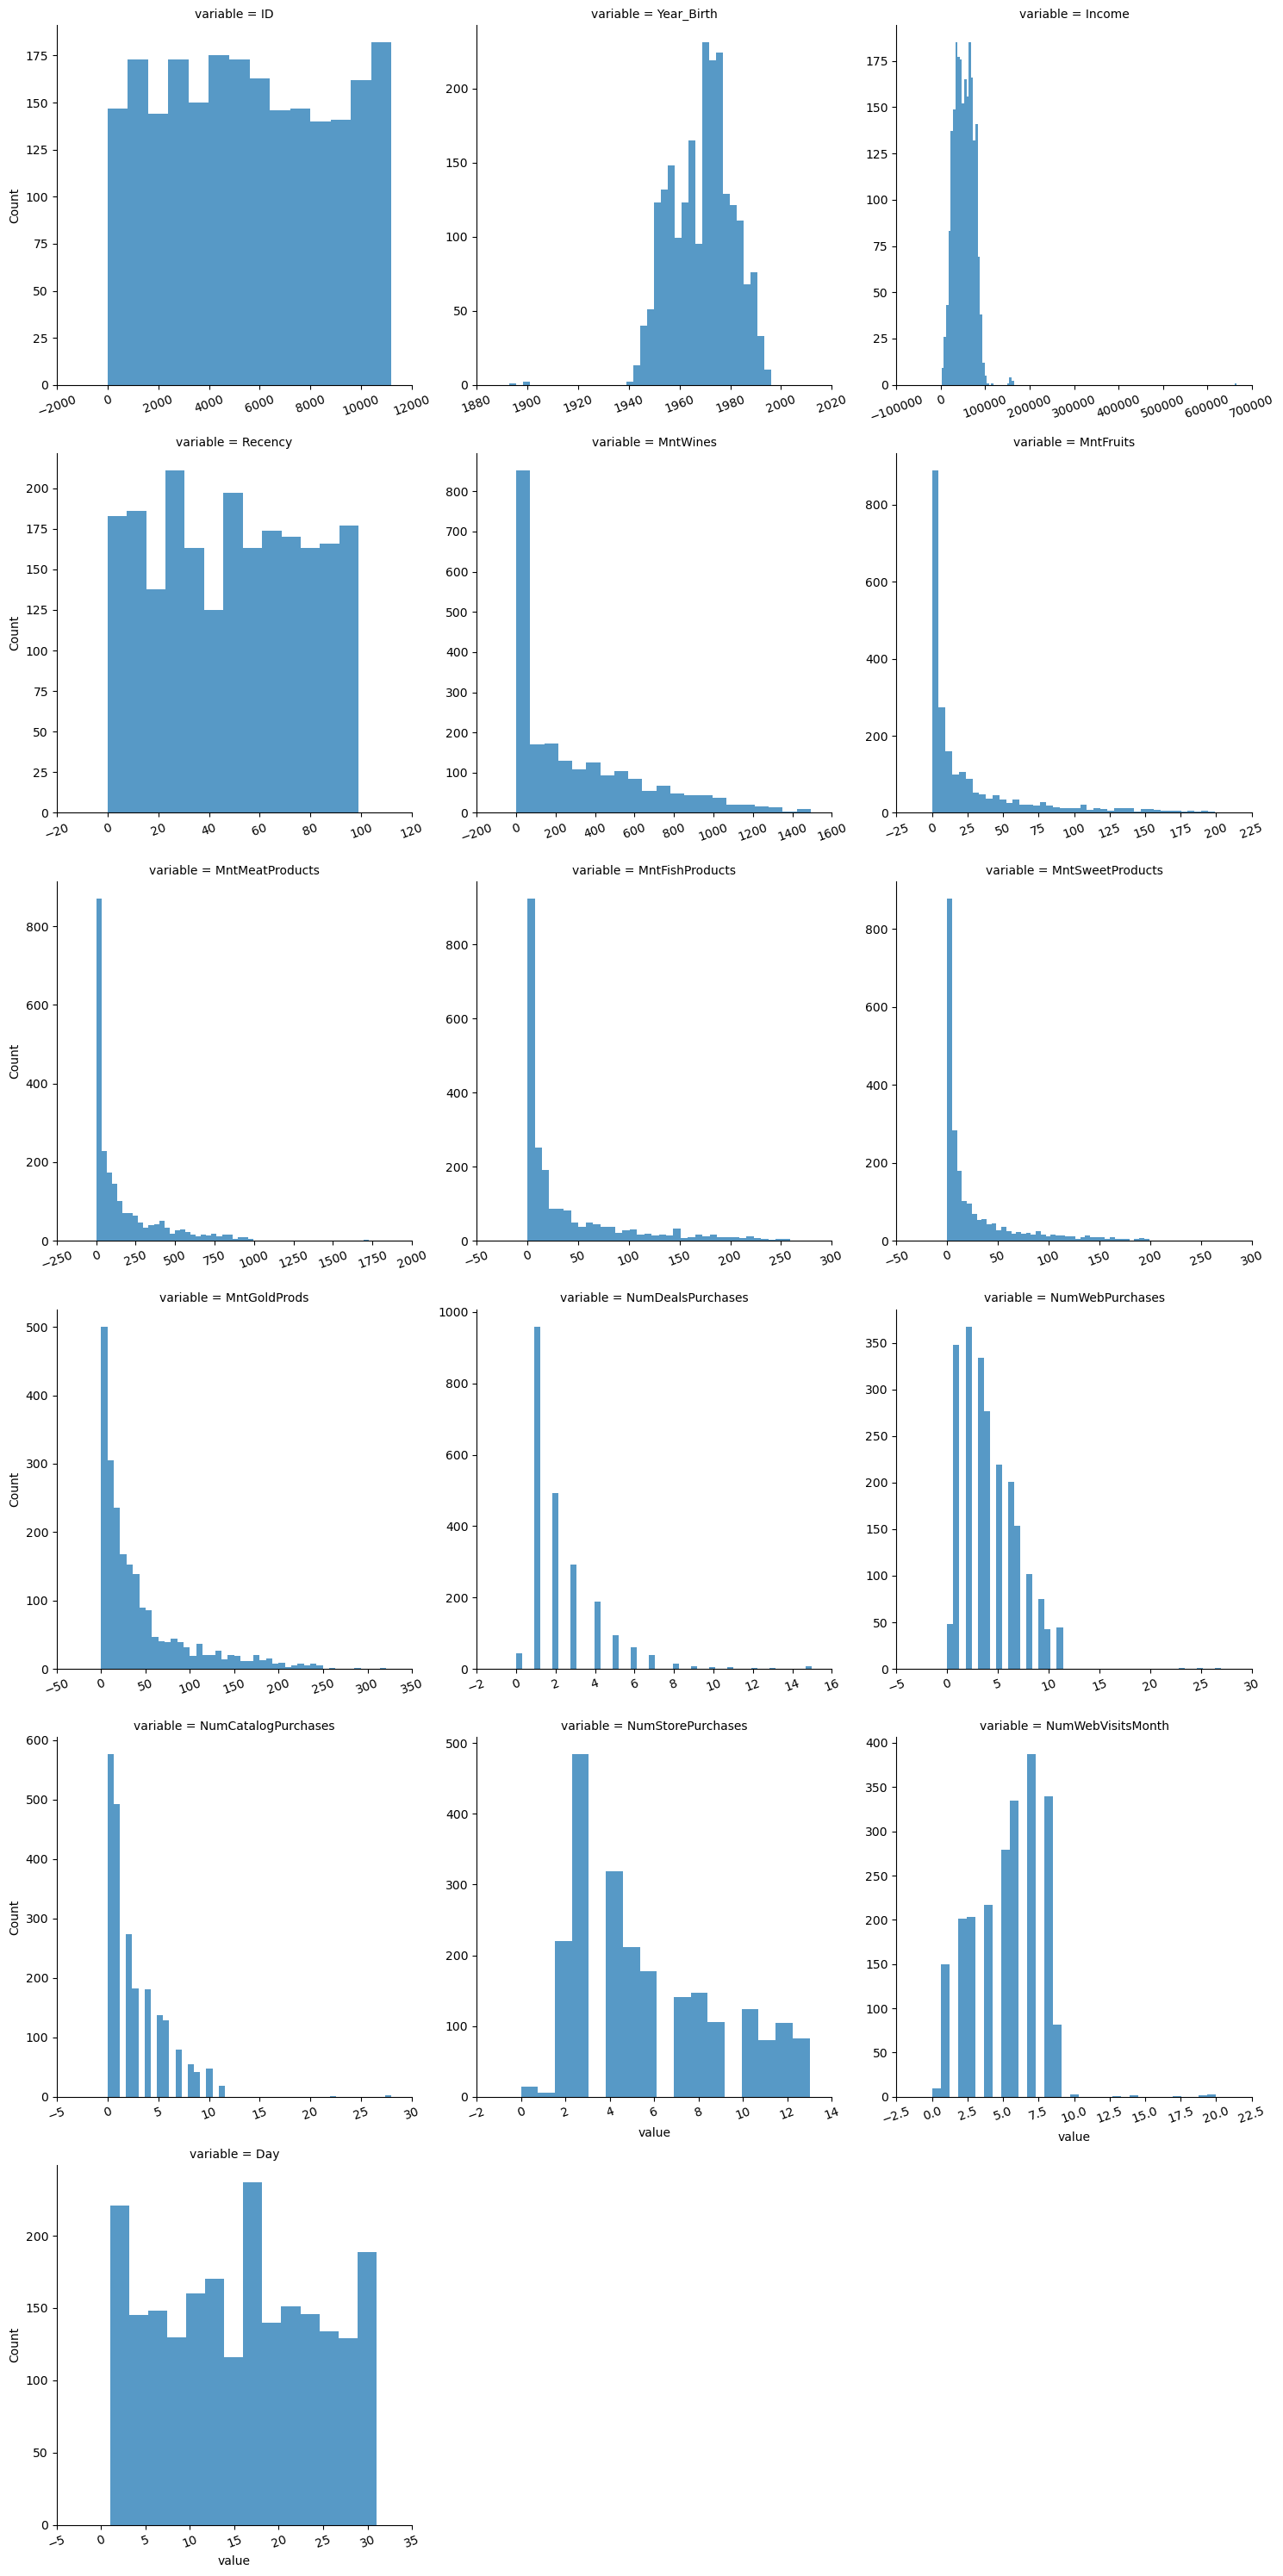

In [18]:
ax = sns.displot(
    x='value',
    data=df.melt(
        value_vars=[f for f in df.columns if ((df[f].nunique()>12) & (f!='Dt_Customer'))]
    ),
    col='variable',
    kind='hist',
    col_wrap=3,
    common_bins=False,
    facet_kws={'sharex':False, 'sharey':False},
)
ax.set_xticklabels(rotation=20)
ax.tight_layout();

Как видно, распределения (кроме **Income** и **Year_Birth**) не являются нормальными - они похожи на экспотенциальные или логнормальные. Также хорошо заметны "длинные хвосты". Посмотрим на выбросы

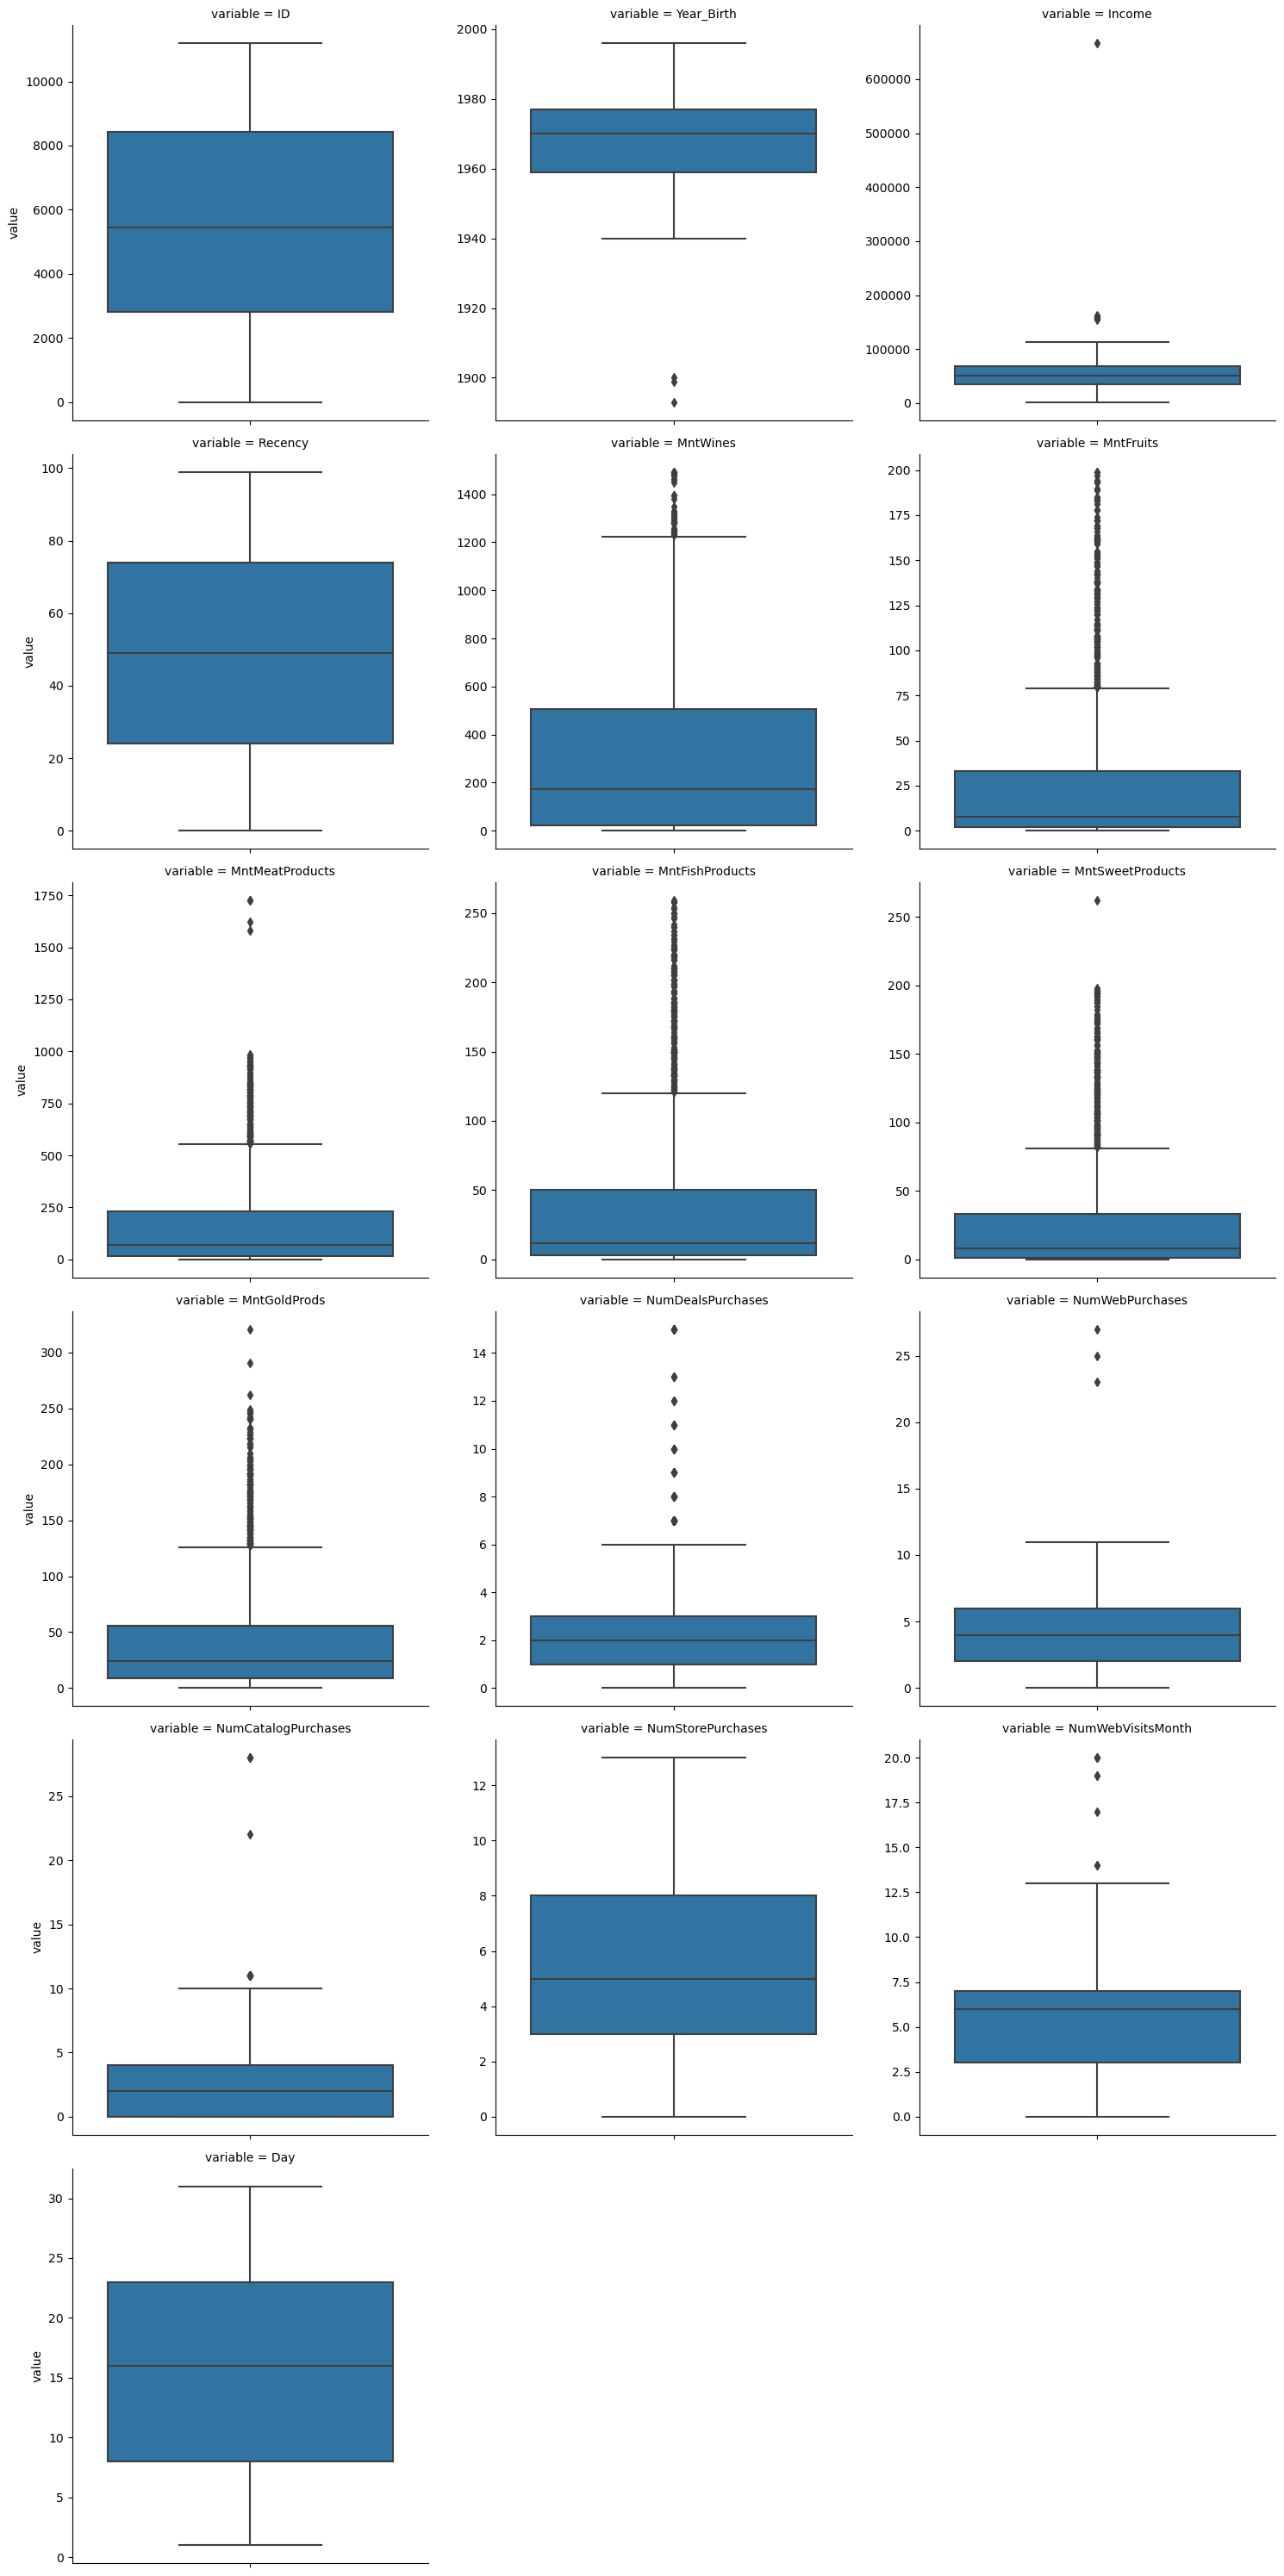

In [19]:
sns.catplot(
    y='value',
    data=df.melt(
        value_vars=[f for f in df.columns if ((df[f].nunique()>12) & (f!='Dt_Customer'))]
    ),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
);

Понятно, что не все значения, которые не попали в интерквартильный размах, являются выбросами. Но, тем не менее, удалим эти значения для упрощения ситуации

## 5. Подготовка данных <a class="anchor" id="5"></a>

### 5.1 Очистка данных (Data Cleaning) <a class="anchor" id="5.1"></a>

[Наверх](#0)

Сначала удалим столбец **ID**

In [20]:
df = df.drop('ID', axis=1)

In [21]:
def calculate_iqr_boundaries(df):
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [22]:
boundaries = pd.DataFrame(calculate_iqr_boundaries(df[df.columns[df.nunique()>12]]))
boundaries.T

0           1
Year_Birth            1932.000    2004.000
Income              -14525.500  118350.500
Recency                -51.000     149.000
MntWines              -697.500    1226.500
MntFruits              -44.500      79.500
MntMeatProducts       -308.375     556.625
MntFishProducts        -67.500     120.500
MntSweetProducts       -47.000      81.000
MntGoldProds           -61.500     126.500
NumDealsPurchases       -2.000       6.000
NumWebPurchases         -4.000      12.000
NumCatalogPurchases     -6.000      10.000
NumStorePurchases       -4.500      15.500
NumWebVisitsMonth       -3.000      13.000
Day                    -14.500      45.500

In [23]:
features_max = [f for f in boundaries.columns if (df[f]>boundaries[f].max()).sum()]
features_min = [f for f in boundaries.columns if (df[f]<boundaries[f].min()).sum()]

In [24]:
for f in features_max:
    df[f][df[f] > boundaries[f][1]] = boundaries[f][1]

In [25]:
for f in features_min:
    df[f][df[f] < boundaries[f][0]] = boundaries[f][0]

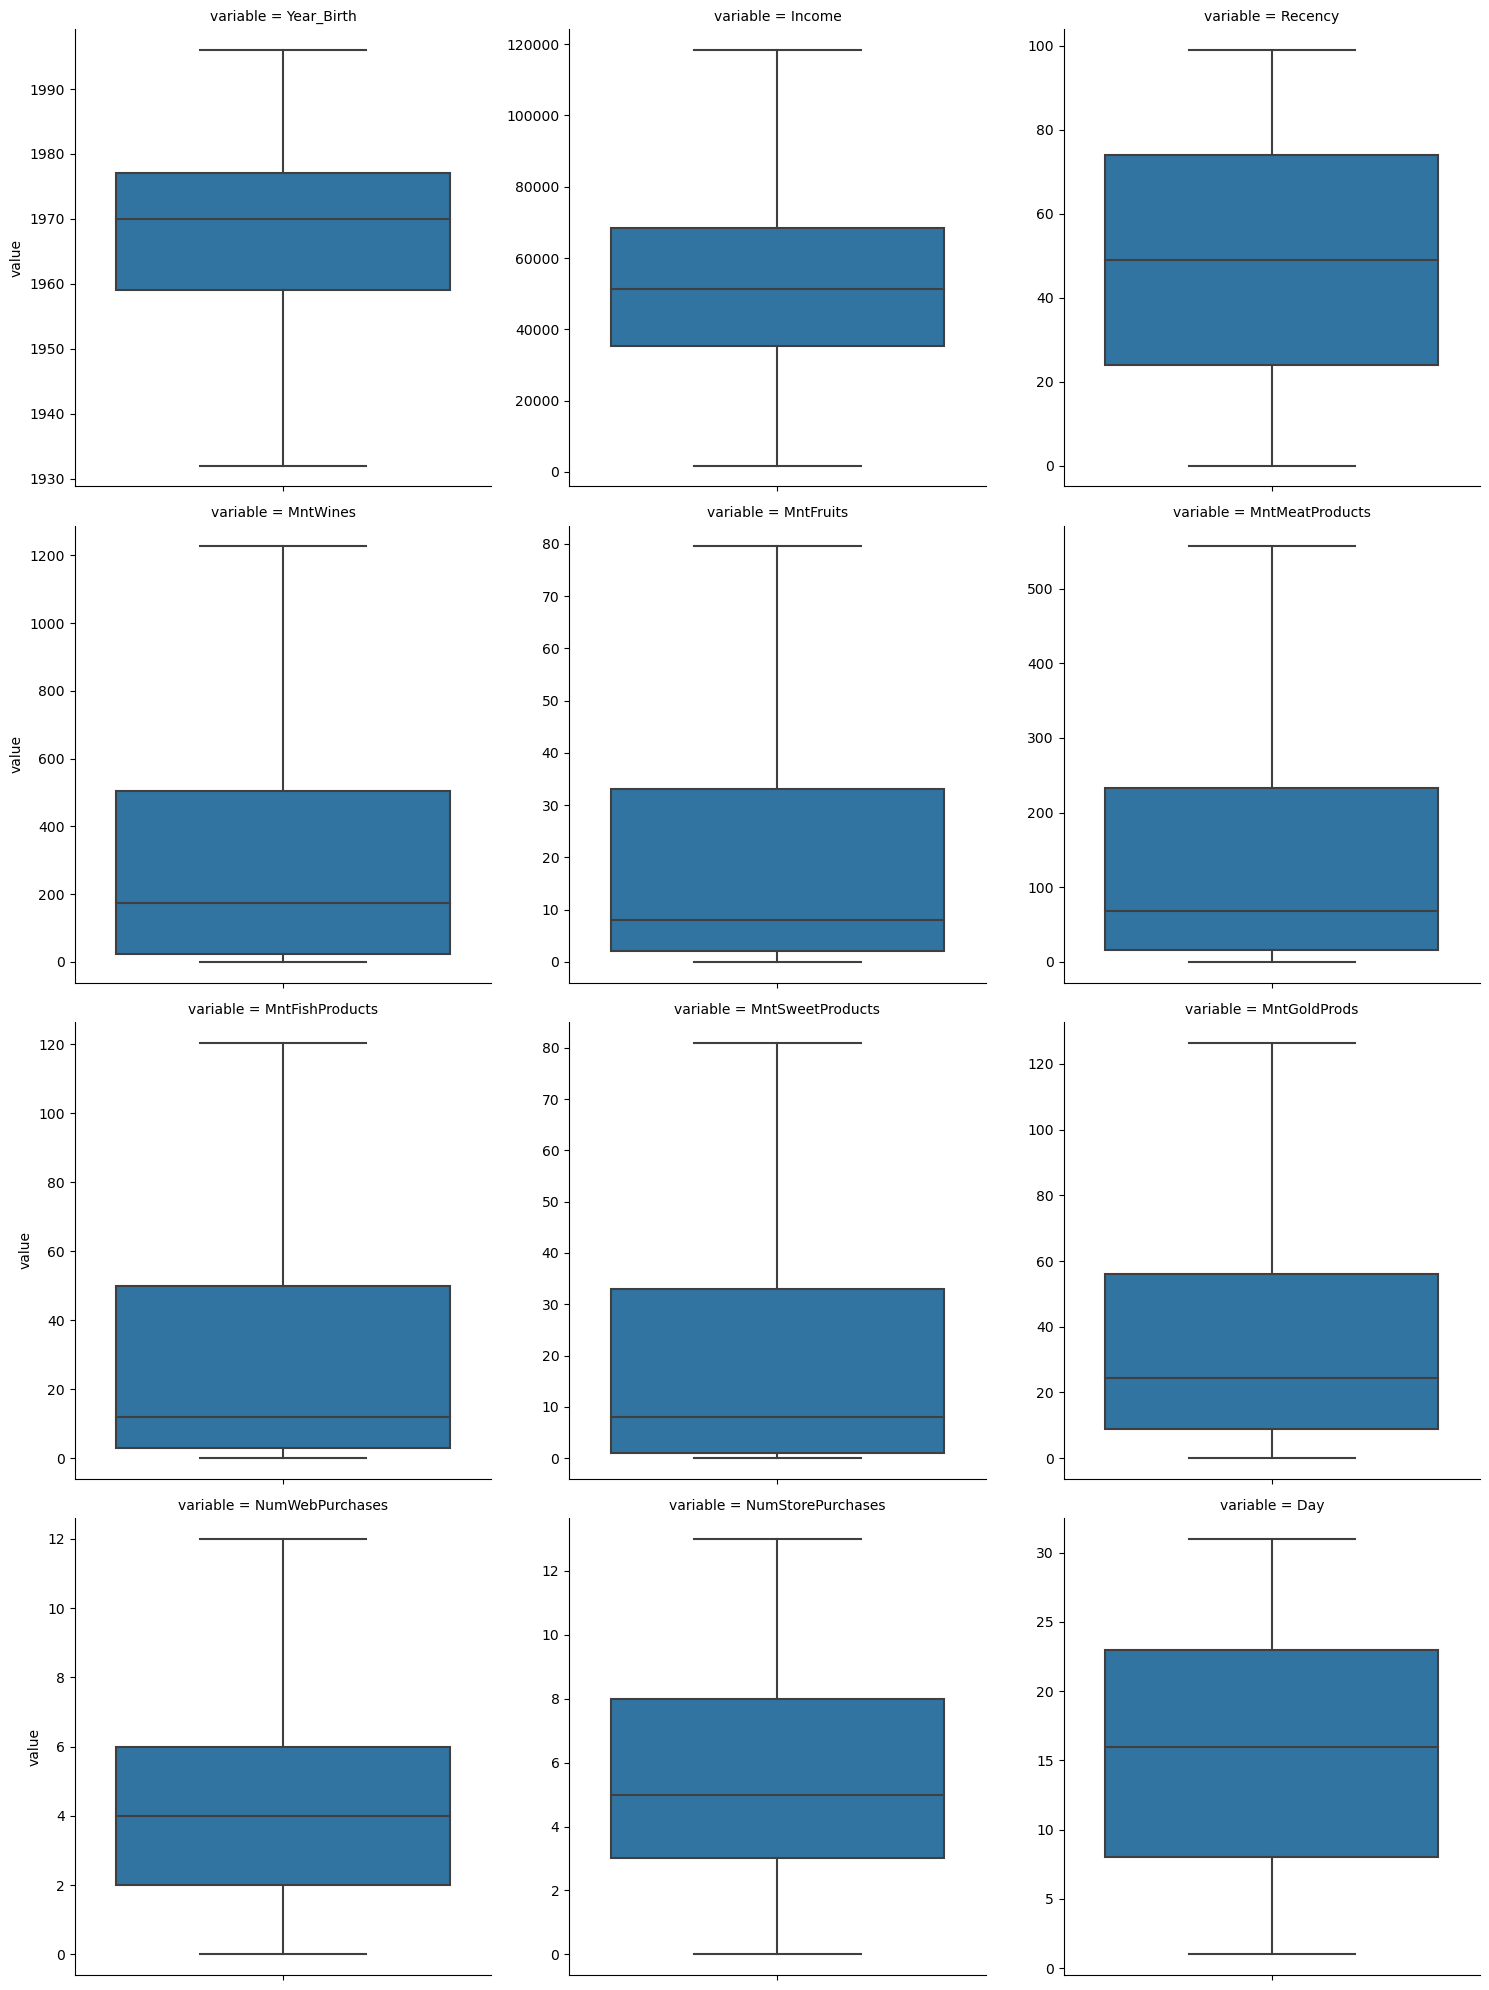

In [26]:
sns.catplot(
    y='value',
    data=df.melt(
        value_vars=[f for f in df.columns if ((df[f].nunique()>12) & (f!='Dt_Customer'))]
    ),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
);

Все значения в норме

### 5.2 Создание новых признаков (Feature Engineering) <a class="anchor" id="5.2"></a>

[Наверх](#0)

Прежде чем начать создавать новые признаки, посмотрим на зависимость **Income** от других значений

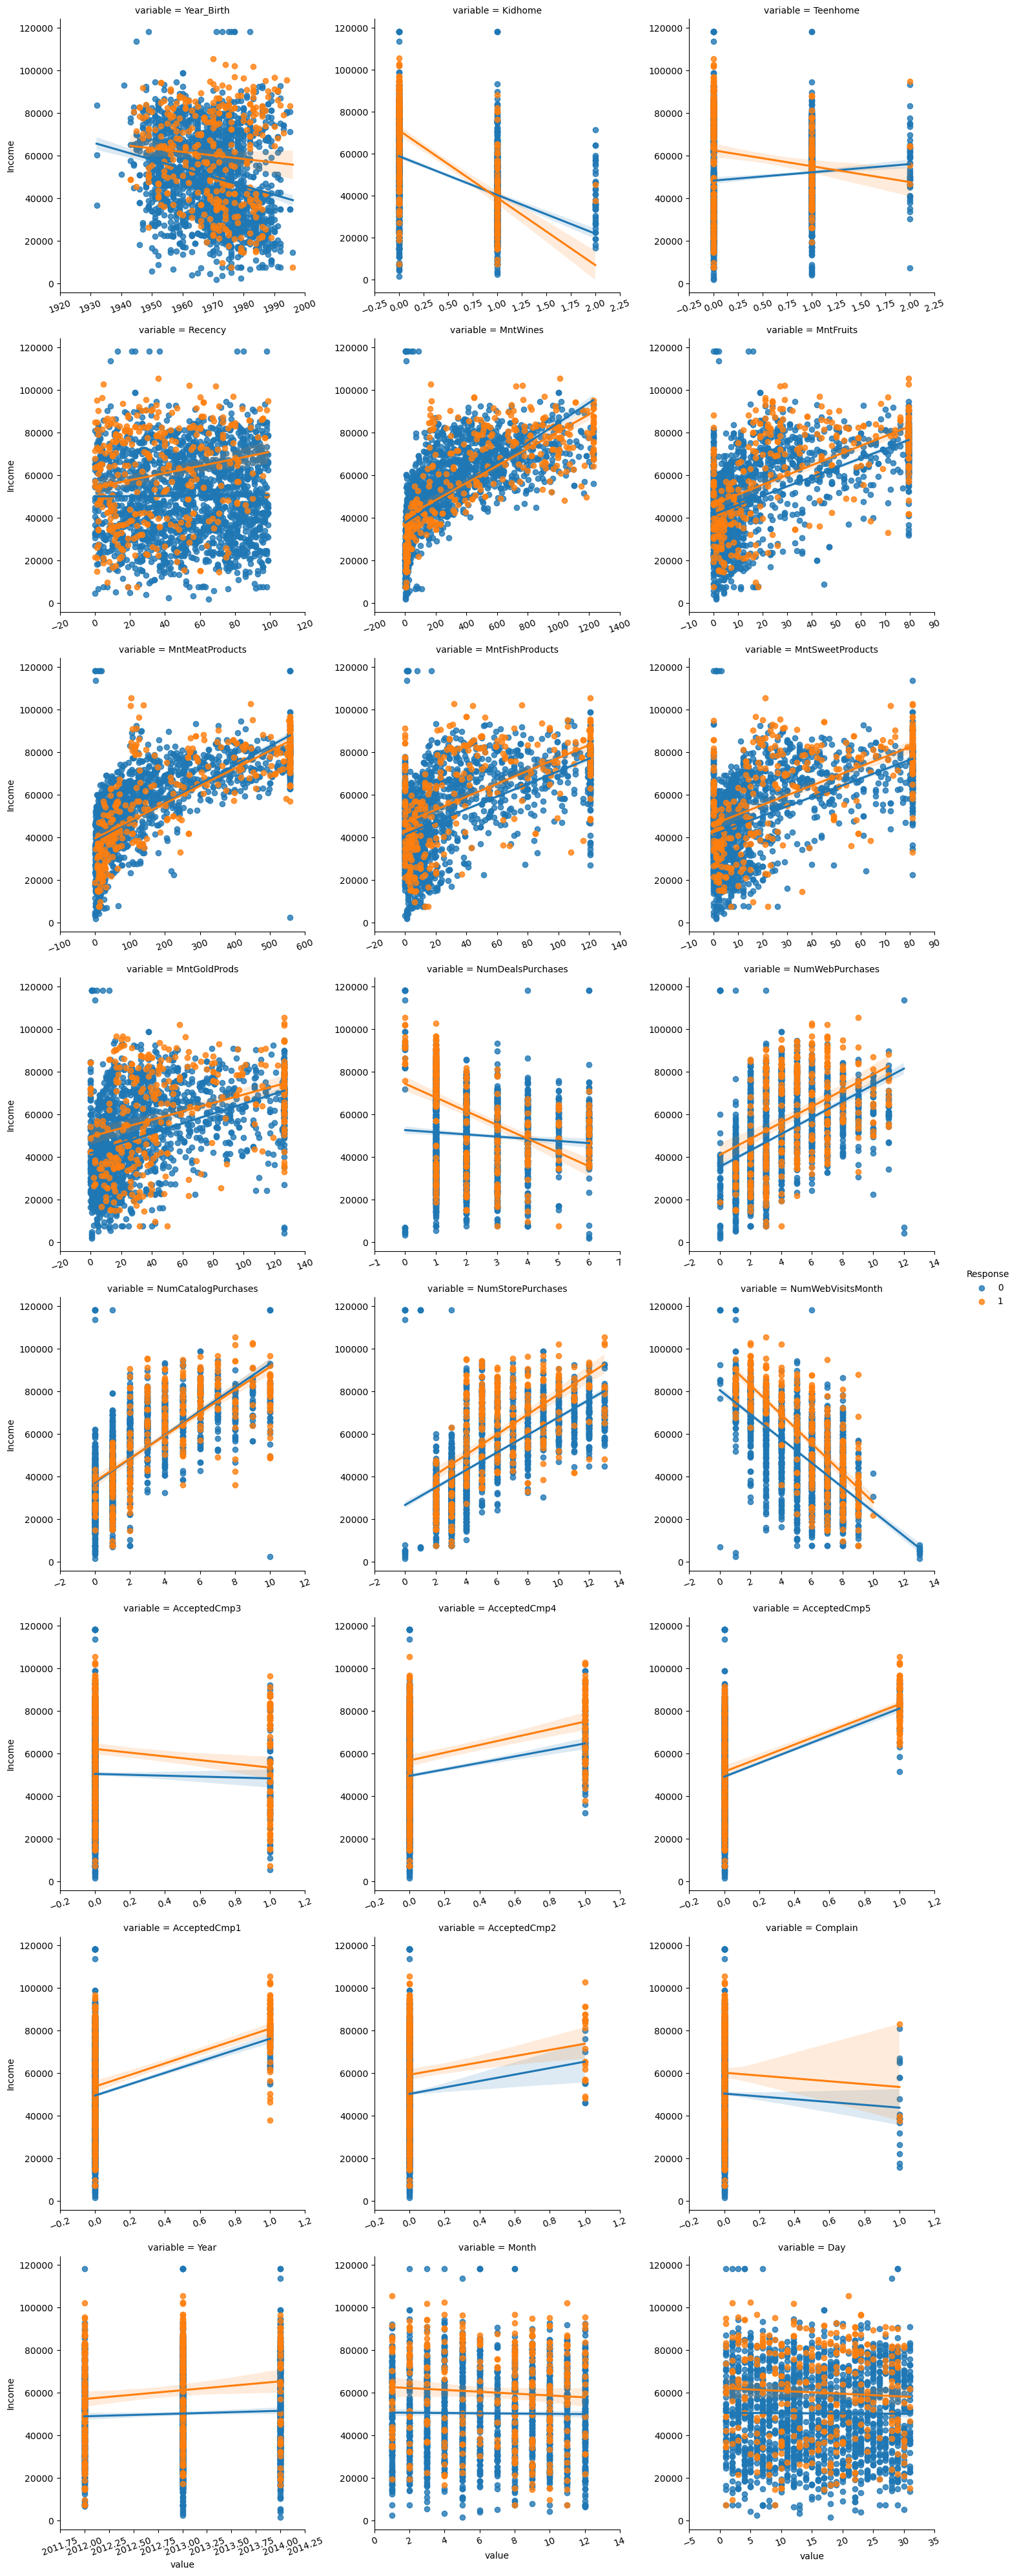

In [27]:
ax = sns.lmplot(
    x='value',
    y='Income',
    data=df.melt(
        id_vars=['Income', 'Response'],
        value_vars=df.select_dtypes(exclude=[object, 'datetime']).columns
    ),
    col='variable',
    hue='Response',
    col_wrap=3,
    sharex=False, 
    sharey=False,
)
ax.set_xticklabels(rotation=20)
ax.tight_layout();

Что интересного можно увидеть из этих графиков:
- чем выше доход клиента, тем больше трат у этого клиента (причём по всем категориям товаров);
- чем выше доход клиента, тем больше покупок у этого клиента (каталог, магазин, интернет);
- с ростом дохода совершается меньше покупок со скидкой (причём это хорошо заметно для тех, кто участвовал в последней компании);
- с ростом дохода совершается меньше визитов на сайт компании;
- чем меньше маленьких детей в семье, тем выше доход клиента (здесь возможна и обратная причинно-следственная связь);
- взрослые дети в семье на доход оказывают разное влияния для разных групп клиентов (которые принимали/не принимали участие в последней компании);
- у людей старшего возраста доход выше, чем у более молодых;
- клиенты с высоким доходом немного чаще откликаются на рекламные компании.

Теперь проанализируем категориальные признаки. Начнём с образования

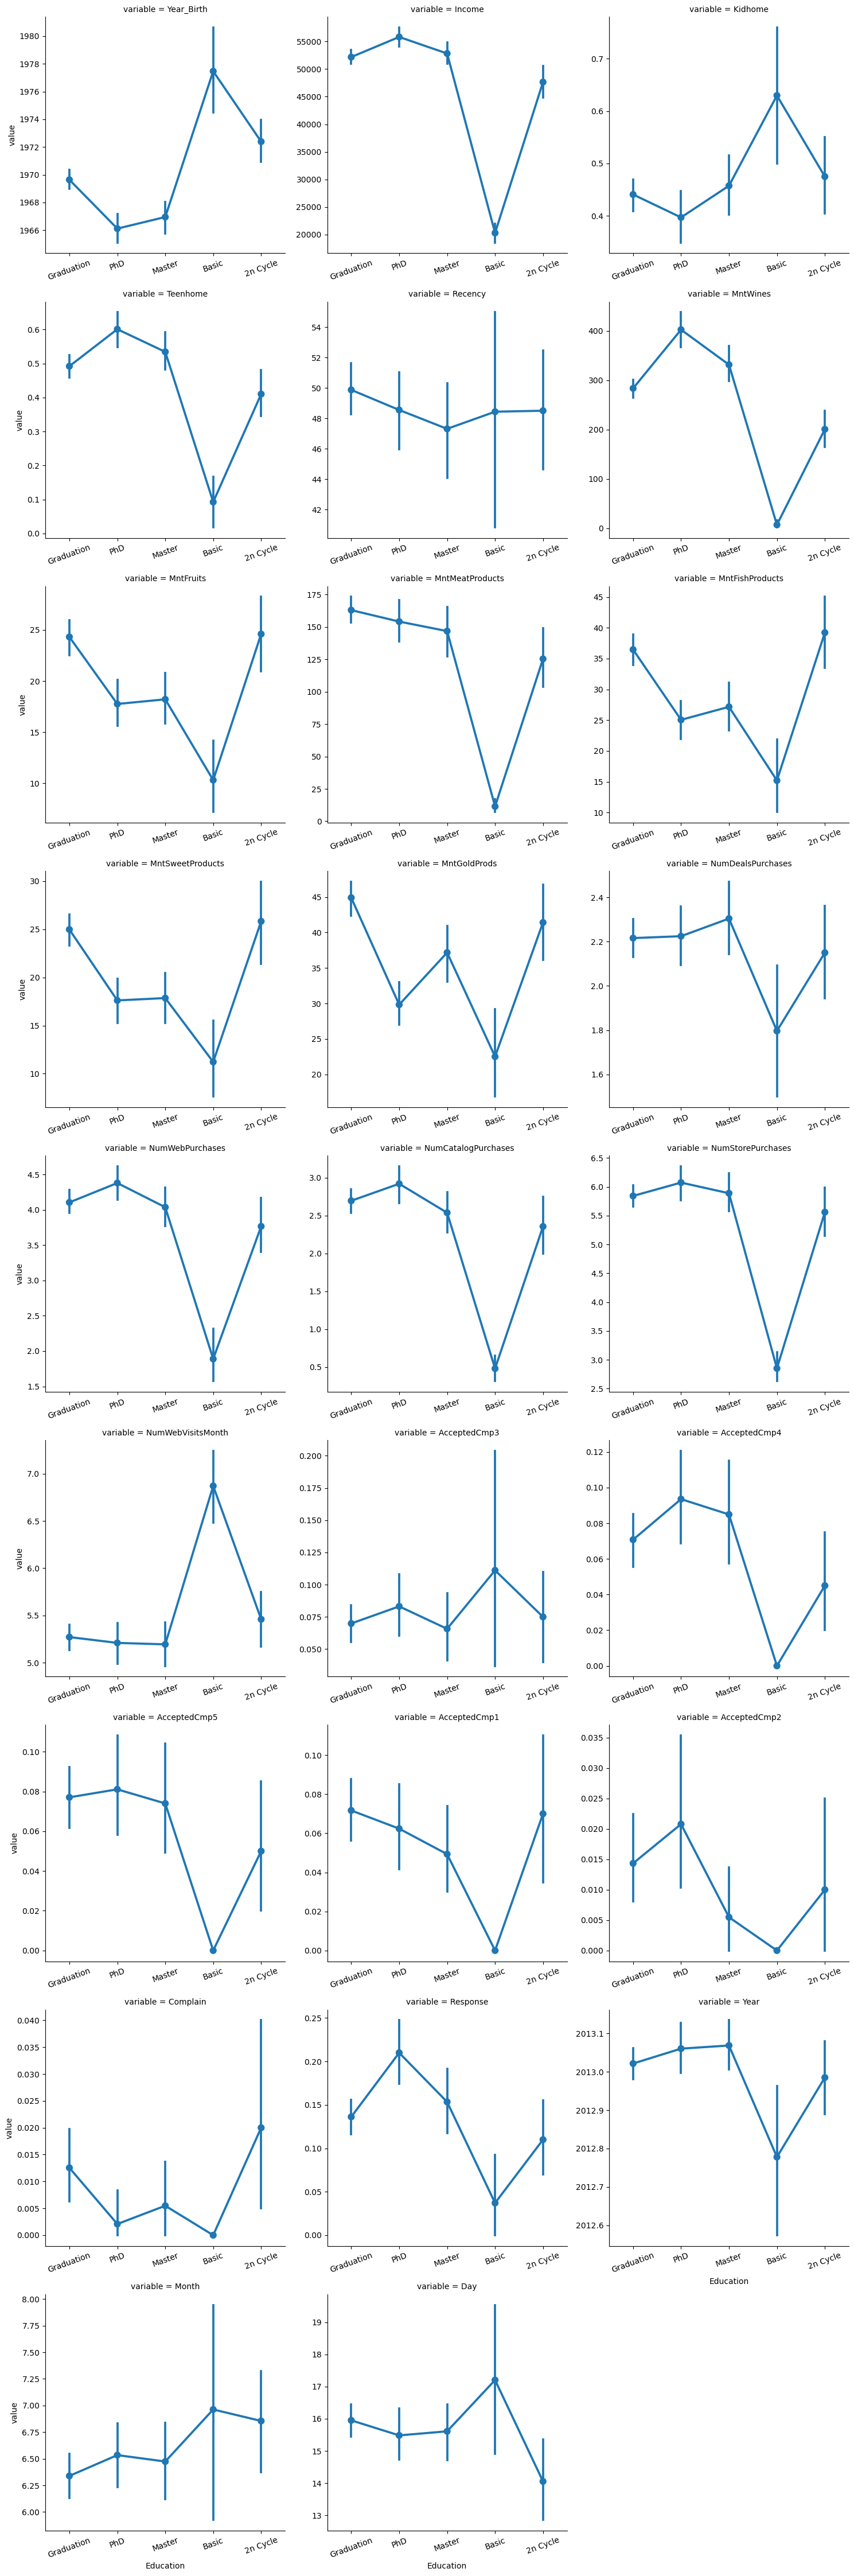

In [28]:
ax=sns.catplot(
    x='Education',
    y='value',
    data=df.melt(
        id_vars=['Education'],
        value_vars=df.select_dtypes(exclude=[object, 'datetime']).columns
    ),
    col='variable',
    kind='point',
    col_wrap=3,
    sharex=False,
    sharey=False,
)
ax.set_xticklabels(rotation=20)
ax.tight_layout();

На данных графиках можно заметить, что клиенты без высшего образования очень сильно отличаются от остальных. При этом поведение клиентов с высшим образованием в целом похоже, не смотря на различные учёные степени. Поэтому для упрощения, можно будет создать бинарный признак, соответствующий наличию или отсутствию высшего образования 

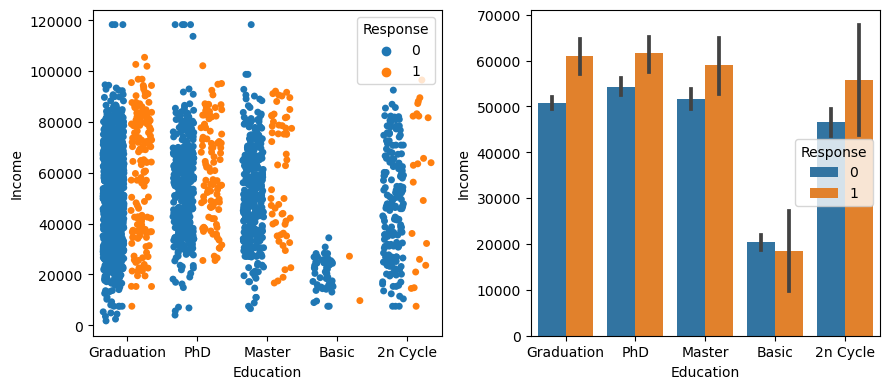

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sns.stripplot(x='Education', y='Income', data=df, hue='Response', jitter=0.3, dodge=True, ax=ax1)
sns.barplot(x='Education', y='Income', data=df, hue='Response', ax=ax2)
plt.tight_layout();

Теперь проанализируем семейное положение

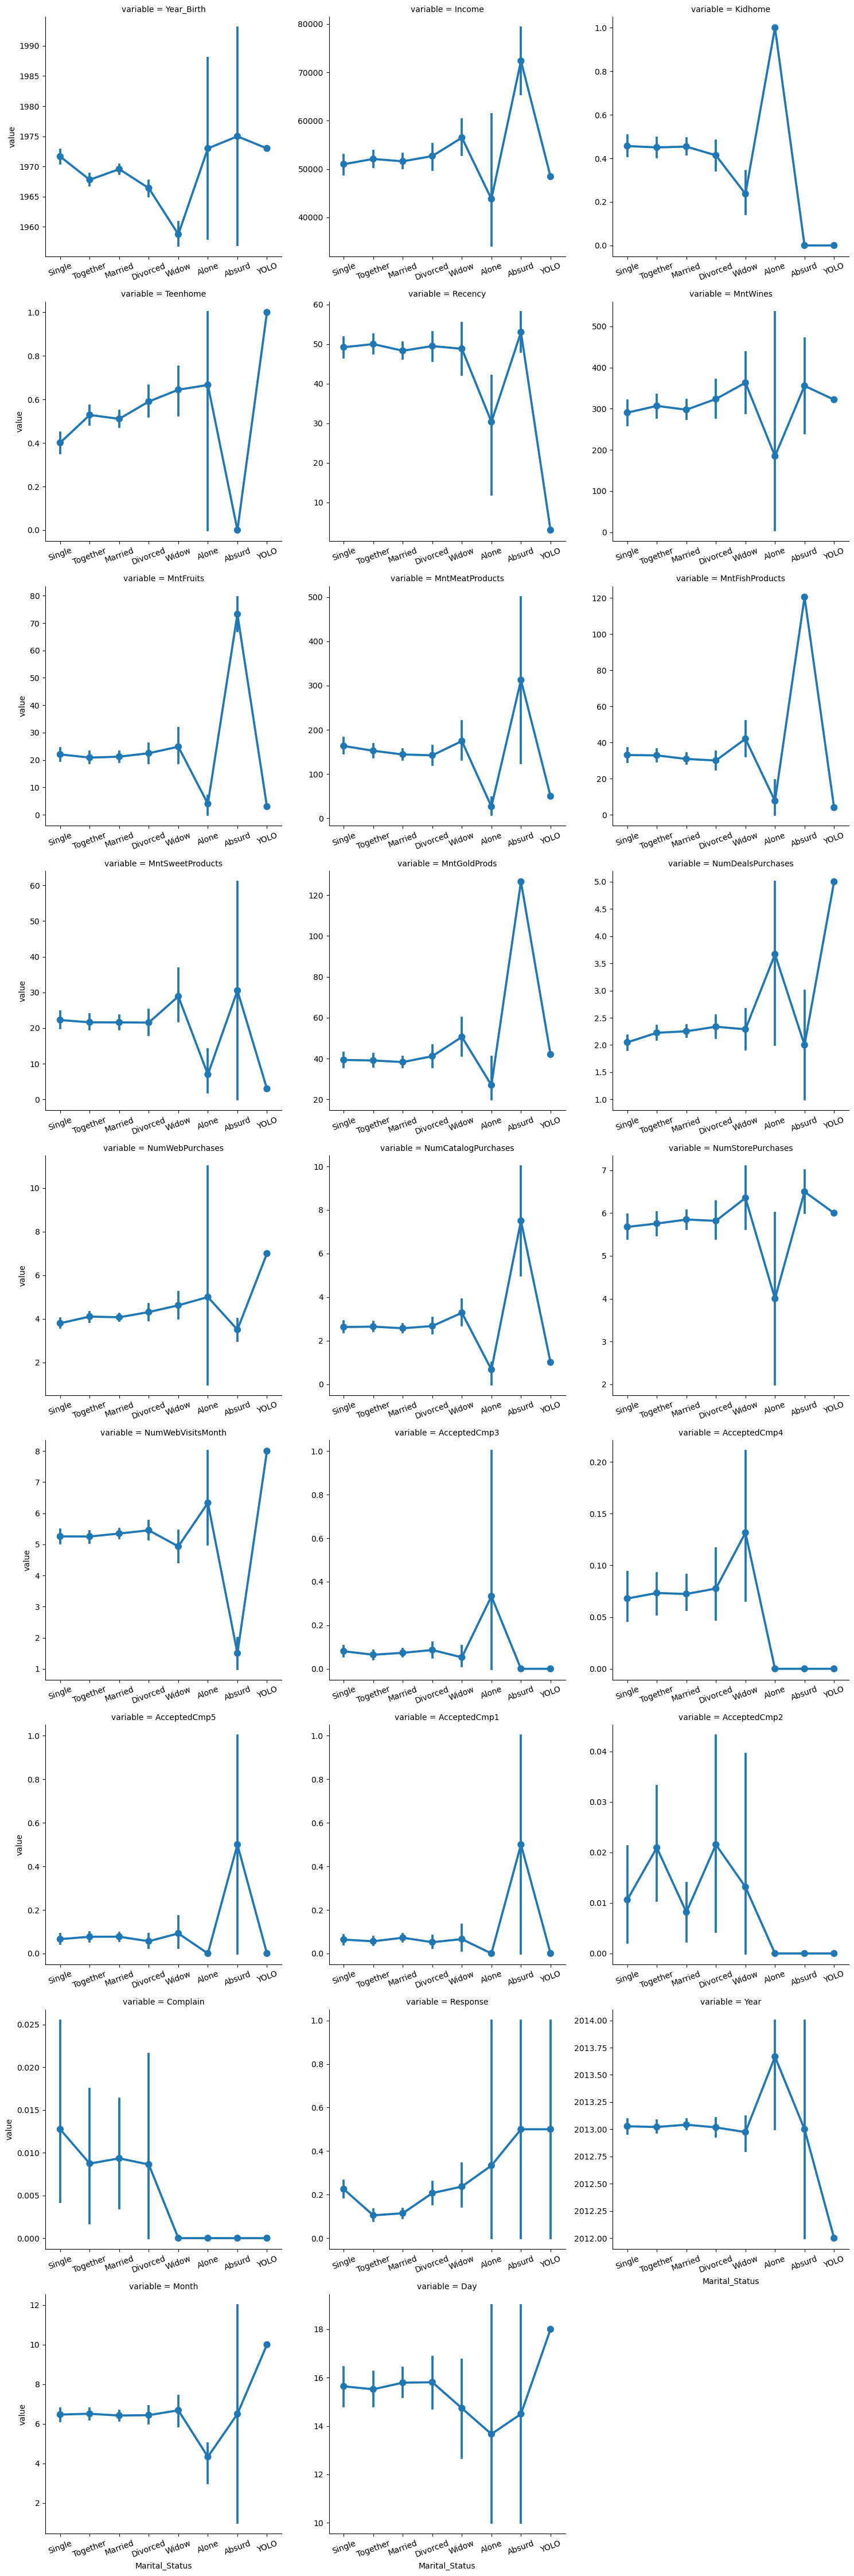

In [30]:
ax=sns.catplot(
    x='Marital_Status',
    y='value',
    data=df.melt(
        id_vars=['Marital_Status'],
        value_vars=df.select_dtypes(exclude=[object, 'datetime']).columns
    ),
    col='variable',
    kind='point',
    col_wrap=3,
    sharex=False,
    sharey=False,
)
ax.set_xticklabels(rotation=20)
ax.tight_layout();

На данных графиках можно заметить, что семейное положение на поведение клиентов не оказывает значимого влияния. Статусы Alone, Absurd, YOLO слишком малочисленны, чтобы учитывать их отклонения. Поэтому, от признака **Marital_Status** целесообразно отказаться

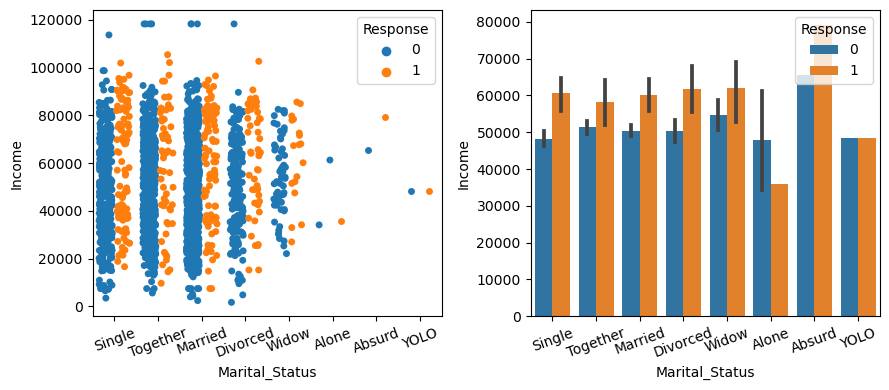

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sns.stripplot(x='Marital_Status', y='Income', data=df, hue='Response', jitter=0.3, dodge=True, ax=ax1)
sns.barplot(x='Marital_Status', y='Income', data=df, hue='Response', ax=ax2)
ax1.tick_params('x', labelrotation=20)
ax2.tick_params('x', labelrotation=20)
plt.tight_layout();

Создадим новый признак, у которого 0 - это отсутствие высшего образования, 1 - в противном случае

In [32]:
df['EduHigh'] = df.apply(lambda x: 0 if x.Education=='Basic' else 1, axis=1)

Теперь создадим новые и более понятные признаки. Посчитаем, сколько времени прошло с момента регистрации пользователя (то есть сколько дней покупатель состоит в программе). Для начала посмотрим, с какой даты началась регистрация клиентов и когда она закончилась

In [33]:
df['Duration'] = df.apply(lambda x: (df.Dt_Customer.max()-x.Dt_Customer).days, axis=1)

Теперь посчитаем траты на все продукты для каждого клиента и их долю от дохода

In [34]:
df['OverallSpend'] = df.apply(
    lambda x: x.MntWines+x.MntFruits+x.MntMeatProducts+x.MntFishProducts+x.MntSweetProducts+x.MntGoldProds, axis=1)

In [35]:
df['PercSpendIncome'] = df.apply(lambda x: x.OverallSpend/x.Income*100, axis=1)

Посчитаем, в каком процентном соотношении на различные продукты тратят клиенты

In [36]:
df['PercWines'] = df.apply(lambda x: x.MntWines/x.OverallSpend*100, axis=1)
df['PercFruits'] = df.apply(lambda x: x.MntFruits/x.OverallSpend*100, axis=1)
df['PercMeat'] = df.apply(lambda x: x.MntMeatProducts/x.OverallSpend*100, axis=1)
df['PercFish'] = df.apply(lambda x: x.MntFishProducts/x.OverallSpend*100, axis=1)
df['PercSweet'] = df.apply(lambda x: x.MntSweetProducts/x.OverallSpend*100, axis=1)
df['PercGold'] = df.apply(lambda x: x.MntGoldProds/x.OverallSpend*100, axis=1)

Далее посчитаем, сколько всего покупок было совершено

In [37]:
df['TotalPurchases'] = df.apply(
    lambda x: x.NumWebPurchases+x.NumStorePurchases+x.NumCatalogPurchases, axis=1)

Найдём какой процент покупок от общего количества был со скидкой. Но сначала проверим, есть ли объекты, у которых признак **TotalPurchases** равен нулю

In [38]:
df[df.TotalPurchases==0]

Year_Birth   Education Marital_Status    Income  Kidhome  Teenhome  \
655         1975  Graduation       Divorced  118350.5        0         0   
981         1965  Graduation       Divorced    4861.0        0         0   
1245        1971  Graduation       Divorced    1730.0        0         0   
1524        1973  Graduation         Single    3502.0        1         0   
1846        1963         PhD        Married    4023.0        1         1   
2132        1949         PhD        Married  118350.5        0         0   

     Dt_Customer  Recency  MntWines  MntFruits  ...  Duration  OverallSpend  \
655   2014-02-07       81       1.0        1.0  ...       142           6.0   
981   2014-06-22       20       2.0        1.0  ...         7           6.0   
1245  2014-05-18       65       1.0        1.0  ...        42           8.0   
1524  2013-04-13       56       2.0        1.0  ...       442           5.0   
1846  2014-06-23       29       5.0        0.0  ...         6           9.0   
2132  2013-08-29       85       2.0        1.0  ...       304           8.0   

      PercSpendIncome  PercWines  PercFruits   PercMeat   PercFish  PercSweet  \
655          0.005070  16.666667   16.666667  16.666667  16.666667  16.666667   
981          0.123431  33.333333   16.666667  16.666667  16.666667   0.000000   
1245         0.462428  12.500000   12.500000  37.500000  12.500000  12.500000   
1524         0.142776  40.000000   20.000000  20.000000   0.000000   0.000000   
1846         0.223714  55.555556    0.000000  11.111111  11.111111  11.111111   
2132         0.006760  25.000000   12.500000  25.000000  12.500000  12.500000   

       PercGold  TotalPurchases  
655   16.666667               0  
981   16.666667               0  
1245  12.500000               0  
1524  20.000000               0  
1846  11.111111               0  
2132  12.500000               0  

[6 rows x 40 columns]

Как видим, такие записи есть. Удалим их

In [39]:
df = df[~(df.TotalPurchases==0)]

In [40]:
df['Discount'] = df.apply(lambda x: x.NumDealsPurchases/x.TotalPurchases*100, axis=1)

Проверим, есть ли клиенты, у которых процент покупок больше 100

In [41]:
df[df['Discount']>100]

Year_Birth   Education Marital_Status  Income  Kidhome  Teenhome  \
1042        1991  Graduation         Single  8028.0        0         0   

     Dt_Customer  Recency  MntWines  MntFruits  ...  OverallSpend  \
1042  2012-09-18       62      73.0       18.0  ...         178.0   

      PercSpendIncome  PercWines  PercFruits   PercMeat  PercFish  PercSweet  \
1042          2.21724  41.011236    10.11236  37.078652  3.932584   6.741573   

      PercGold  TotalPurchases  Discount  
1042  1.123596               1     600.0  

[1 rows x 41 columns]

Да, есть один клиент, у которого 600 % покупок было со скидкой. Удалим этого клиента

In [42]:
df = df[~(df['Discount']>100)]

Найдём среднюю стоимость одной покупки

In [43]:
df['AvgSpendPurchases'] = df.apply(lambda x: x.OverallSpend/x.TotalPurchases, axis=1)

Далее создадим признак **Age**. Будем считать на момент июня 2014 года

In [44]:
df['Age'] = df.apply(lambda x: 2014-x.Year_Birth, axis=1)

Посчитаем, сколько у клиента всего детей (маленьких и взрослых)

In [45]:
df['Child'] = df.apply(lambda x: x.Kidhome+x.Teenhome, axis=1)

Пересчитаем доход клиента с учётом количества иждивенцев

In [46]:
df['AvgIncome'] = df.apply(lambda x: x.Income/(x.Child+1), axis=1)

Посчитаем, какую долю составляют дни, с момента последней покупки. Для этого сначала узнаем, есть ли такие клиенты, у которых дней с момента последней покупки больше времени, которое прошло с момента регистрации

In [47]:
df[df.Recency > df.Duration][['Dt_Customer', 'Recency', 'Duration']]

Dt_Customer  Recency  Duration
45    2014-06-28       72         1
53    2014-06-07       54        22
88    2014-05-12       70        48
94    2014-05-24       84        36
112   2014-06-25       27         4
...          ...      ...       ...
2182  2014-04-23       96        67
2187  2014-05-11       60        49
2199  2014-06-26       65         3
2223  2014-06-25       33         4
2236  2014-06-10       56        19

[143 rows x 3 columns]

Как видим, есть таких 143 объекта. Это явная ошибка. Удалим эти строки

In [48]:
df = df[~(df.Recency > df.Duration)]
df['PercRecency'] = df.apply(lambda x: x.Recency/x.Duration*100, axis=1)

Узнаем количество компаний, в которых принимал участие клиент

In [49]:
df['TotalAccepted'] = df.apply(
    lambda x: x.AcceptedCmp1+x.AcceptedCmp2+x.AcceptedCmp3+x.AcceptedCmp4+x.AcceptedCmp5, axis=1)

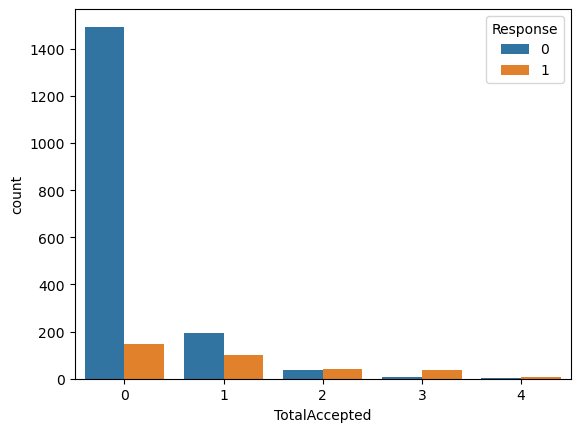

In [50]:
sns.countplot(x='TotalAccepted', data=df, hue='Response');

Теперь удалим некоторые столбцы

In [51]:
cols_to_drop = ['Year_Birth', 'Education', 'Marital_Status',
                'Kidhome', 'Teenhome', 'Dt_Customer',
                'MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds',  'AcceptedCmp1', 'AcceptedCmp2',
                'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                'NumDealsPurchases', 'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases',
                'NumWebVisitsMonth', 'Year', 'Month', 'Day']
                
df = df.drop(cols_to_drop, axis=1)

Посмотрим на распределения оставшихся признаков

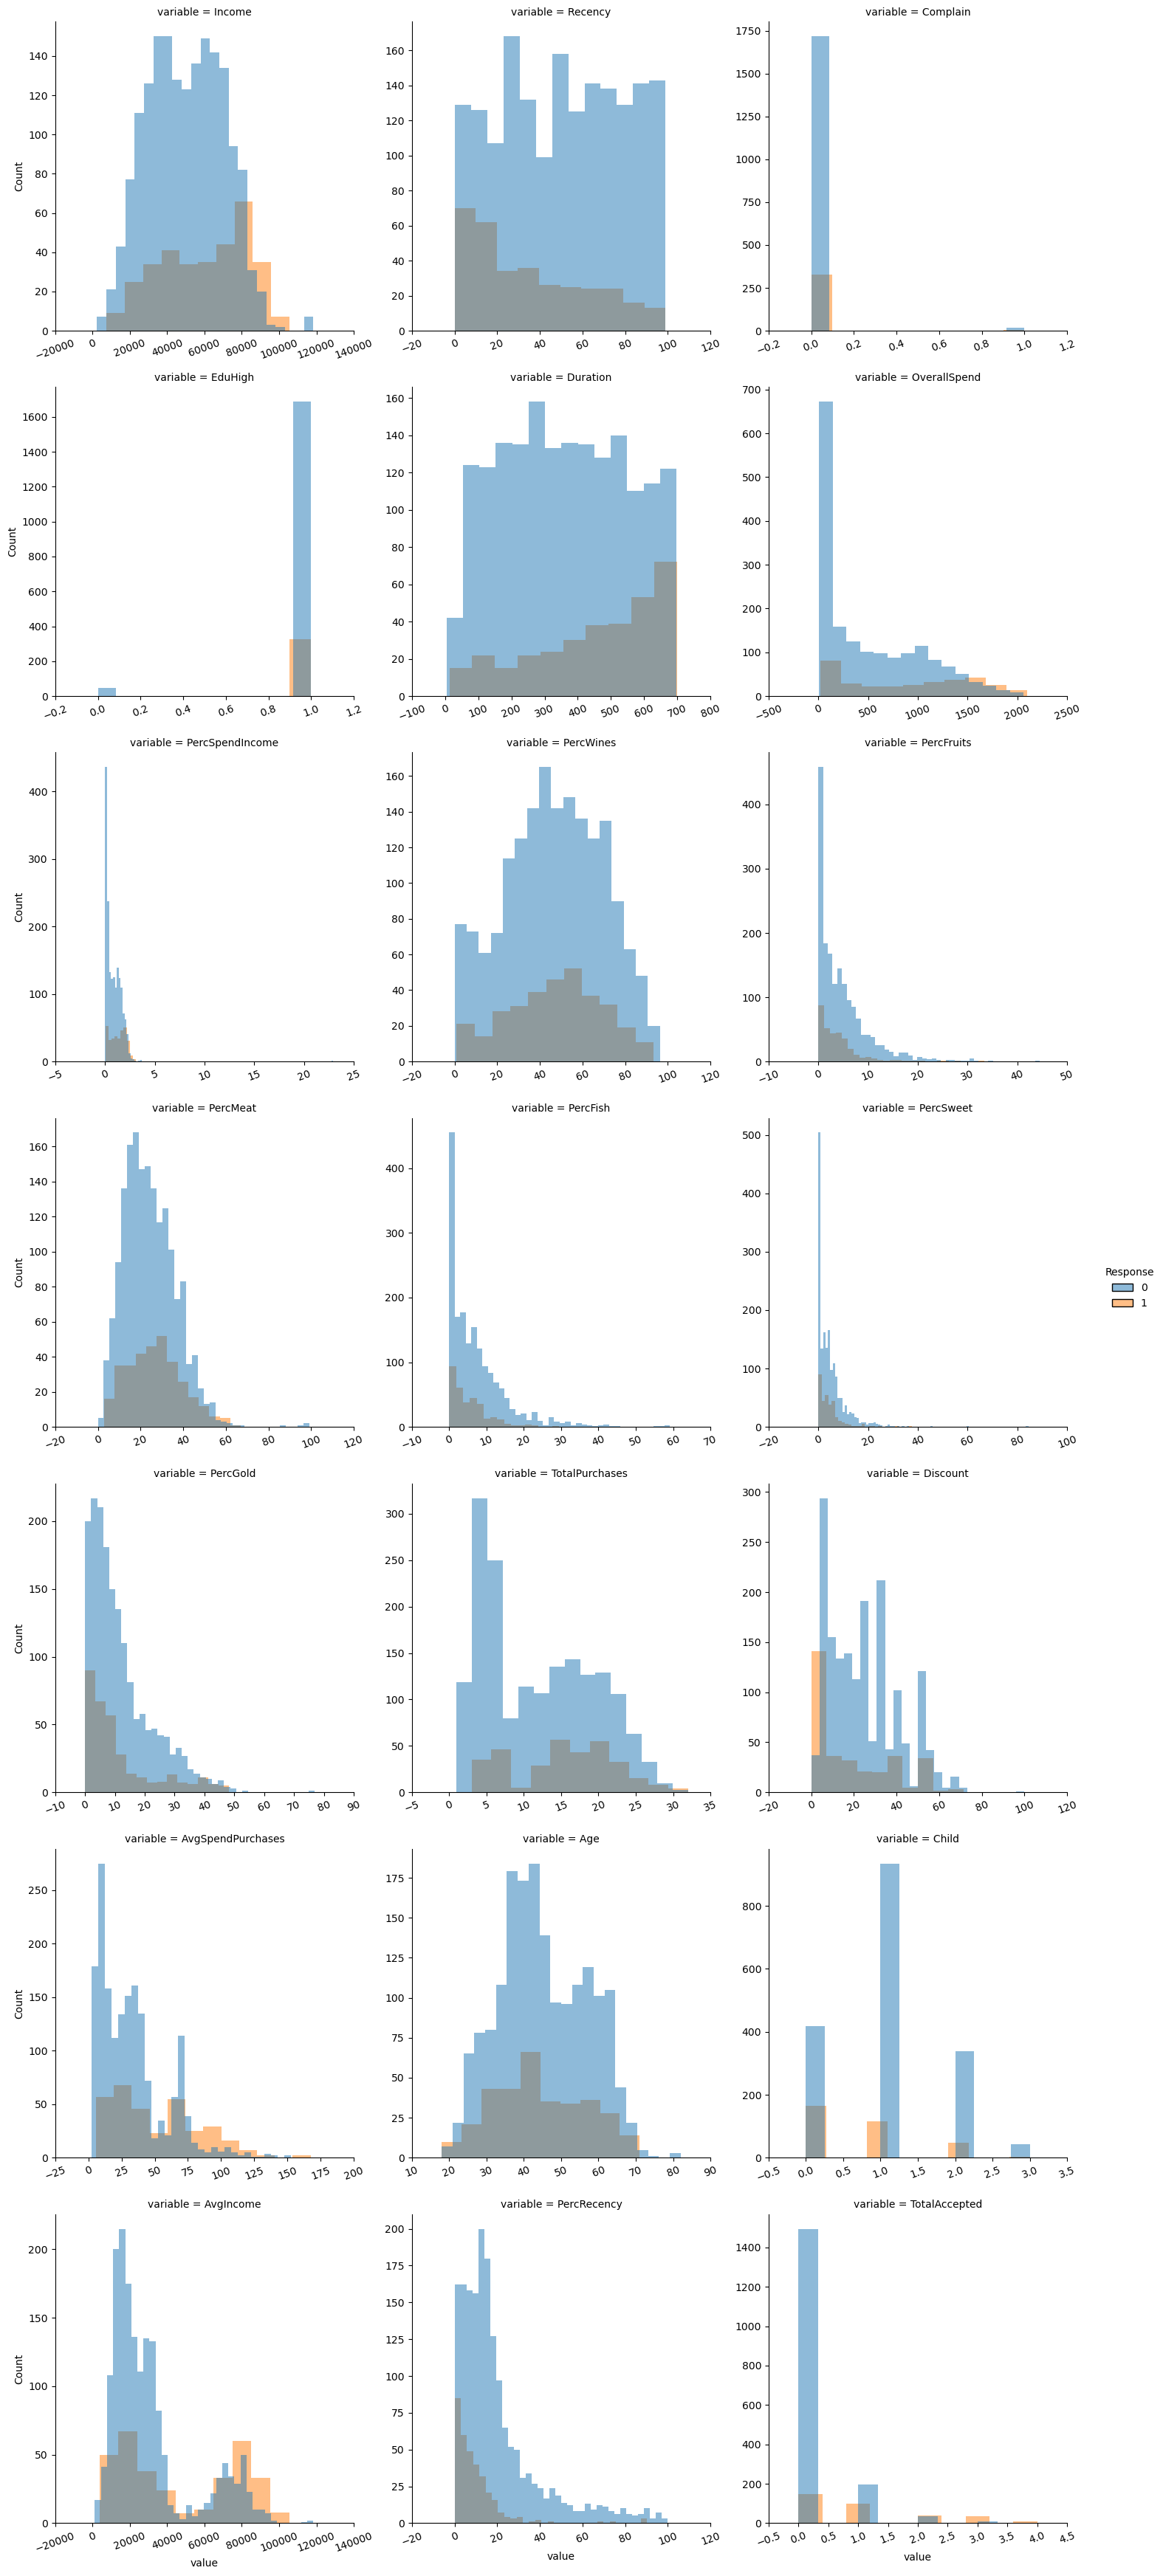

In [52]:
ax=sns.displot(
    x='value',
    hue='Response',
    data=df.melt(
        id_vars=['Response'],
        value_vars=df
    ),
    col='variable',
    kind='hist',
    col_wrap=3,
    common_bins=False,
    facet_kws={'sharex':False, 'sharey':False}
)
ax.set_xticklabels(rotation=20)
ax.tight_layout();

## 6. Кластеризация <a class="anchor" id="6"></a>

[Наверх](#0)

Прежде чем приступить к кластеризации, сделаем масштабирование наших признаков

In [53]:
std = StandardScaler()
df_std = std.fit_transform(df)
df_std = pd.DataFrame(df_std, columns=df.columns, index=df.index)
df_std.head()

Income   Recency  Complain  Response   EduHigh  Duration  OverallSpend  \
0  0.304773  0.350650 -0.101336  2.293601  0.159092  1.510506      1.770648   
1 -0.258520 -0.339526 -0.101336 -0.435996  0.159092 -1.384973     -1.002107   
2  0.948354 -0.753632 -0.101336 -0.435996  0.159092 -0.337336      0.361513   
3 -1.199318 -0.753632 -0.101336 -0.435996  0.159092 -1.248096     -0.954772   
4  0.312176  1.592968 -0.101336 -0.435996  0.159092 -1.132277     -0.282975   

   PercSpendIncome  PercWines  PercFruits  ...  PercSweet  PercGold  \
0         2.002416  -0.254623    0.090603  ...   0.075597 -0.586703   
1        -1.013747  -0.264645   -0.186849  ...  -0.191391  0.956843   
2         0.172152   0.360357    0.321351  ...  -0.366363 -0.611431   
3        -0.851080  -1.147038    0.561314  ...   0.151823 -0.236237   
4        -0.243842  -0.253408    1.075680  ...   0.281226 -0.784761   

   TotalPurchases  Discount  AvgSpendPurchases       Age     Child  AvgIncome  \
0        1.309364 -0.607658           1.278099  1.011446 -1.273407   1.001749   
1       -1.206921  1.589431          -1.075397  1.266084  1.413885  -0.732333   
2        1.029777 -1.129466           0.108656  0.332410 -1.273407   1.549107   
3       -0.927334  0.582432          -0.998430 -1.280299  0.070239  -0.818652   
4        0.191015  0.726289          -0.211173 -1.025661  0.070239  -0.175896   

   PercRecency  TotalAccepted  
0    -0.516801      -0.438269  
1     0.804735      -0.438269  
2    -0.538833      -0.438269  
3     0.012070      -0.438269  
4     2.119715      -0.438269  

[5 rows x 22 columns]

Построим модель кластеризации с помощью метода k-средних. Определим оптимальное количество кластеров с помощью метода локтя и метрики *silhouette score*

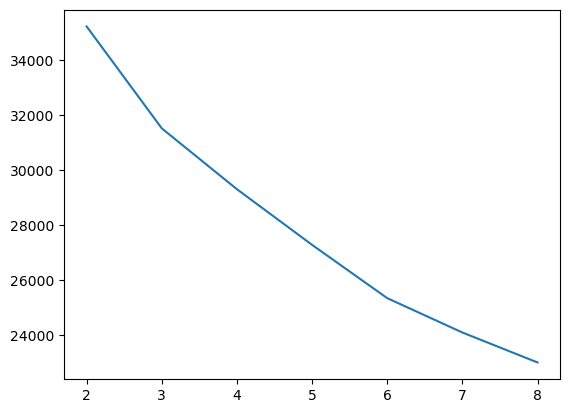

In [54]:
n_clusters = list(range(2, 9))

metrics = []

for k in n_clusters:
    km = KMeans(n_clusters=k).fit(df_std)
    metrics.append(km.inertia_)

plt.plot(n_clusters, metrics);

По методу локтя предпочтительным результатом является значение 3. Теперь посмотрим по значениям силуэта

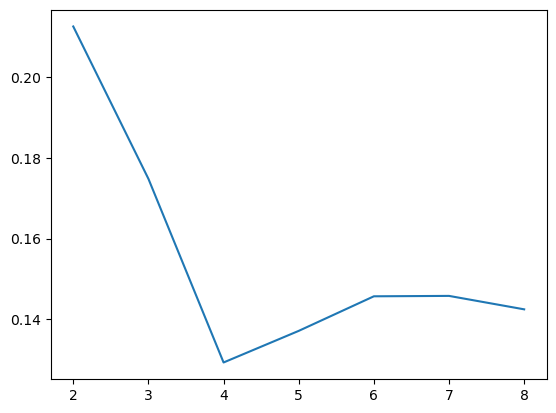

In [55]:
n_clusters = list(range(2, 9))

scores = []

for k in n_clusters:
    km = KMeans(n_clusters=k).fit(df_std)
    scores.append(silhouette_score(df_std, km.labels_))

plt.plot(n_clusters, scores);

Здесь наибольшее значение метрики соответствует двум кластерам. Остановимся на значении 3

In [56]:
km = KMeans(n_clusters=3)
cluster = km.fit_predict(df_std)

Посмотрим на получившиеся центроиды кластеров

In [57]:
centers = std.inverse_transform(km.cluster_centers_)
centers = pd.DataFrame(centers, columns=df.columns)
centers.T.style.format('{:.2f}')

При таком делении на три группы мы видим:
- предпочтения по продуктам для кластеров отличаются: для кластеров 0 и 1 больше половины всех покупок приходится на винную продукцию, в то время как во 2-м кластере предпочтение отдаётся мясу, рыбе, золотым украшениям;
- кластеры отличаются по возрастному составу: второй кластер немного моложе, чем остальные;
- траты на продукты у кластеров отличаются очень сильно: 1-й кластер тратит в 5 раз больше чем 0-й и в 10 раз больше, чем 2-й;
- группы отличаются по участию в рекламных кампаниях (в последней и пяти предыдущих): 25 %  в 1-м класере против 10 % в остальных группах (в 2,5 раза разница);
- все участники 0-го и 1-го кластера имеют высшее образование, в то время как во 2-м кластере состав смешанный;
- группы отличаются по наличию детей: в 1-м кластере у большинства дети отсутствуют, а больше всего детей у представителей 1-го кластера.

Визуализируем наши кластеры

In [58]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
df_emb = tsne.fit_transform(df_std)

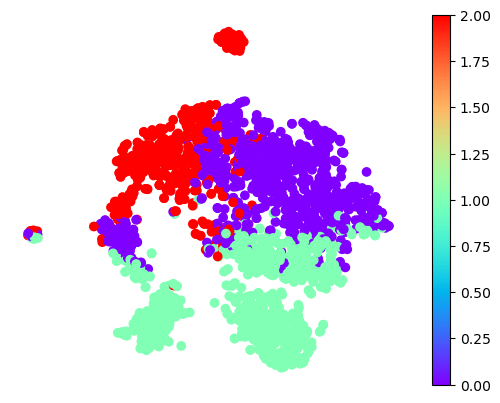

In [59]:
plt.scatter(df_emb[:, 0], df_emb[:, 1], c=km.labels_, cmap='rainbow')
plt.axis('off')
plt.colorbar();

In [60]:
df['cluster'] = cluster

Сосчитаем, сколько процентов от общего количества покупателей составляет каждая группа

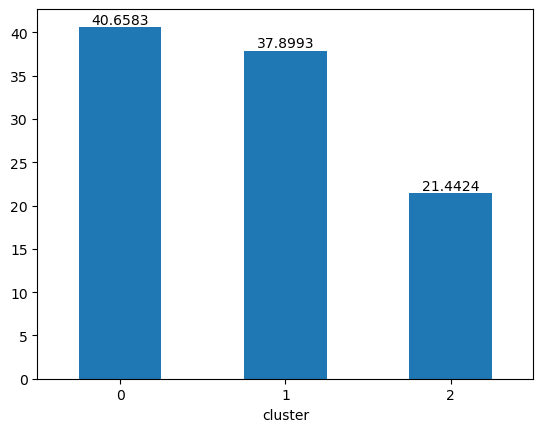

In [61]:
ax = (100*df.groupby('cluster').size()/df.shape[0]).plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)

И посмотрим какой вклад вносит каждая группа в общую выручку

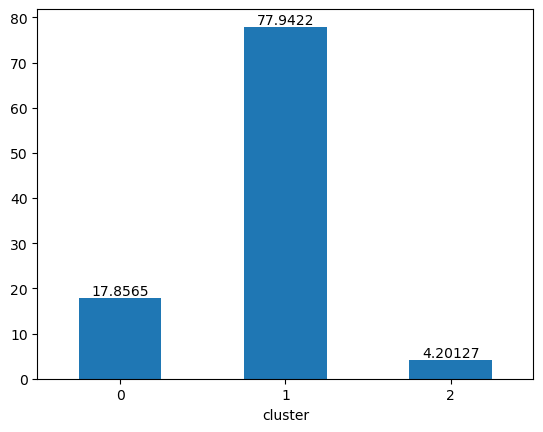

In [62]:
ax = (100*df.groupby('cluster').OverallSpend.sum()/df.OverallSpend.sum()).plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)

**0-й кластер:** класс покупателей со средними тратами. По численности превышает первый кластер, но по доле общего дохода всего 18 %.

**1-й кластер:** класс покупателей, которые тратят больше всего. Класс второй по численности (38 %), но приносит наибольший доход (78 %).

**2-й кластер:** класс покупателей, которые тратят меньше всего. Этом самый малочисленный класс и доля в общей прибыли едва превышает 4 %.

Теперь посчитаем, насколько в каждой группе значения по каждому признаку отличаются от общих средних значений

In [63]:
df_final = df.groupby('cluster').agg({x: 'mean' for x in df.columns}).T
stat = np.array([[df[feature].apply('mean')] for feature in df.columns]).flatten()

In [64]:
for label in range(3):
    df_final[label] = 100 * df_final[label] / stat - 100

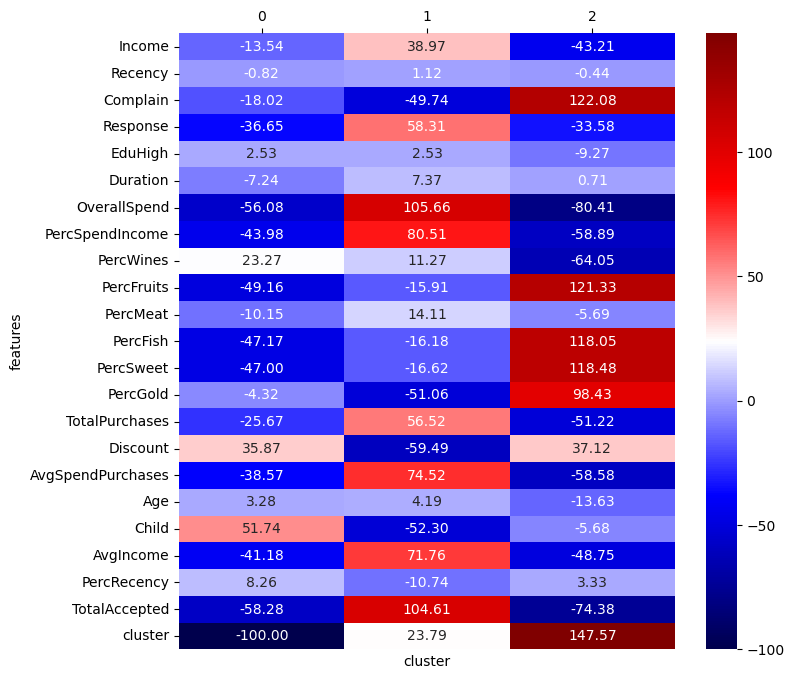

In [65]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(df_final, annot=True, fmt='.2f', cmap='seismic')
ax.set(ylabel='features')
ax.xaxis.tick_top()

## 7. Заключение <a class="anchor" id="7"></a>

[Наверх](#0)

К ранее описанным профилям классов можно добавить то, что нулевой кластер должен быть следующей целью рекламной кампании. Во-первых, это кластер самый многочисленный и у него очень огромный потенциал. Во-вторых, клиенты из этого кластера тратят всего 0.5 % от дохода (для сравнения клиенты 1-го кластера тратят 1.5 %). Поэтому, если получится заставить данных покупателей больше тратить, то это позволит увеличить прибыль компании. Так, учитывая, что у представителей нулевого кластеро больше всего детей, можно сделать акцент на детские товары. Ну и важно не потерять клиентов первого кластера, так как это ключевая категория покупателей, на долю которых приходится 78 % всего дохода.